# Crowd Counting

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools

from tqdm import trange
from torchvision.transforms import v2
from torchvision import datasets, transforms
from torch.utils.data import Dataset, TensorDataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error

%matplotlib inline

/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

In [2]:
np.random.seed(2)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Data Review

In [3]:
# Load the data
df = pd.read_csv("labels.csv")

In [4]:
# Map each id to its appropriate file name
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

In [5]:
df.describe()

,id,count
count,2000.000000,2000.000000
mean,1000.500000,31.157500
std,577.494589,6.945417
min,1.000000,13.000000
25%,500.750000,26.000000
50%,1000.500000,31.000000
75%,1500.250000,36.000000
max,2000.000000,53.000000


<Axes: >

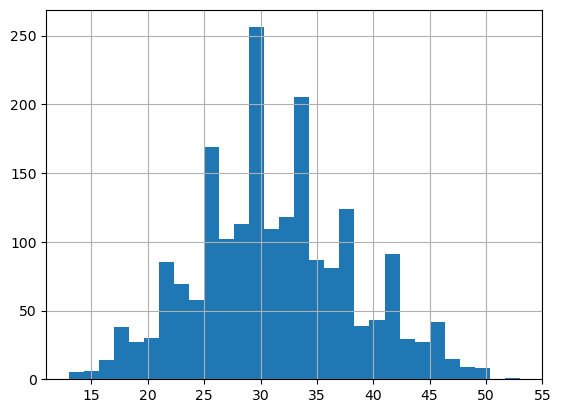

In [6]:
df['count'].hist(bins=30)

## 2. Load Image Data

In [7]:
images = np.load('images.npy')
labels = np.load('labels.npy')

In [8]:
print(images.shape)

(2000, 480, 640, 3)


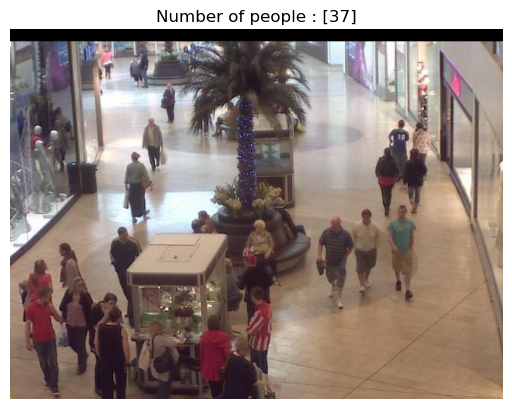

In [9]:
# Generate 1 random numbers within the range
random_numbers = np.random.randint(0, len(images), size=1)

# Display the images corresponding to the random numbers
for number in random_numbers:
    image = images[number]
    plt.imshow(image)
    plt.title(f"Number of people : {labels[number]}")
    plt.axis('off')
    plt.show()

In [10]:
# Define a transform for image data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
# Transform the data
transformed_images = []
for img in images:
    img = Image.fromarray(img)
    transformed_images.append(transform(img))
transformed_images= torch.stack(transformed_images)

/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [12]:
# Split the data
train_images, test_images = train_test_split(transformed_images, test_size=0.2, random_state=42)
train_labels, test_labels = train_test_split(labels, test_size=0.2, random_state=42)

In [13]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

torch.Size([1600, 3, 256, 256])
(1600, 1)
torch.Size([400, 3, 256, 256])
(400, 1)


In [14]:
# Create dataset and dataloaders
train_dataset = TensorDataset(torch.tensor(train_images).float(), torch.tensor(train_labels).float())
test_dataset = TensorDataset(torch.tensor(test_images).float(), torch.tensor(test_labels).float())

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

/tmp/ipykernel_22096/1940908756.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_images).float(), torch.tensor(train_labels).float())
/tmp/ipykernel_22096/1940908756.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_images).float(), torch.tensor(test_labels).float())


## Define CSRNet Model

In [15]:
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels = 512, dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

def make_layers(cfg, in_channels = 3, batch_norm=False, dilation=False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [16]:
csr_model = CSRNet()
csr_optimizer = torch.optim.Adam(csr_model.parameters(), lr=0.001)
csr_criterion = nn.SmoothL1Loss()
csr_epochs = 10

In [17]:
print(csr_model)

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

## Define Simple CNN Model

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=8, stride=8),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.ReLU(True),
            nn.Flatten()
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

In [19]:
cnn_model = SimpleCNN()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
cnn_criterion = nn.SmoothL1Loss()
cnn_epochs = 50

In [20]:
print(cnn_model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)


## Define Mobile Net

In [21]:
mobile_net_model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
mobile_net_model.classifier[3] = nn.Linear(mobile_net_model.classifier[3].in_features, 1)
mobile_net_criterion = nn.MSELoss()
mobile_net_optimizer = torch.optim.Adam(mobile_net_model.parameters(), lr=0.002)
mobile_net_epochs = 70

In [22]:
print(mobile_net_model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

## Define VGG

In [41]:
vgg_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg_model.classifier[-1] = nn.Linear(vgg_model.classifier[-1].in_features, 1)
vgg_criterion = nn.MSELoss()
vgg_optimizer = torch.optim.Adam(vgg_model.parameters(), lr=0.001)
vgg_epochs = 60

In [42]:
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Prepare for Training & Testing

In [25]:
def train_one_epoch(train_loader, model, device, optimizer, 
                    log_interval, epoch, criterion, batch_size):
    model.train()
    losses = []
    counter = []
    index_count = 0
    total_loss = 0.0
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)
        # ------------------
        # Write your implementation here.
        optimizer.zero_grad()
        outputs = model(img)
        outputs_summed = outputs.view(outputs.size(0), -1).sum(1, keepdim=True)
        loss = criterion(outputs_summed, label)
        loss.backward()
        optimizer.step()
        # ------------------
        index_count += 1
        total_loss += loss.item()
        # Record training loss every log_interval and keep counter of total training images seen
        if i % 20 == 0:
            print(f'Epoch [{epoch+1}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
        if (0 == (index_count+1) % log_interval):
            losses.append(loss.item())
            counter.append((index_count * batch_size) + img.size(0) + epoch * len(train_loader.dataset))
    return losses, counter

In [26]:
def test_one_epoch(test_loader, model, device, criterion):
    model.eval()
    model.to(device)
    test_loss = 0.0
    num_correct = 0
    count = 0
    with torch.no_grad():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)
            # ------------------
            # Write your implementation here.
            outputs = model(img)
            outputs_summed = outputs.view(outputs.size(0), -1).sum(1, keepdim=True)
            loss = criterion(outputs_summed, label)
            predicted = torch.round(outputs_summed)
            num_correct += (predicted == label).sum().item()
            test_loss += loss.item()
            count += 1
            # ------------------
    test_loss /= count
    # test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

In [27]:
def plt_loss_graph(trainloader, train_counter, train_losses, test_losses):

    fig = plt.figure(figsize=(12,8))
    plt.plot(train_counter, train_losses, label='Train loss')
    plt.plot([i * len(trainloader.dataset) for i in range(1, len(test_losses) + 1)],
             test_losses, label='Test loss', marker='o')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.title('Loss curve', fontsize=24)
    plt.xlabel('Number of training examples seen', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc='upper right', fontsize=14)

In [28]:
def model_train(trainloader, testloader, model, device,
                criterion, optimizer, max_epochs, batch_size):
    # Recording data
    log_interval = 100

    train_losses = []
    train_counter = []
    test_losses = []
    test_correct = []
    for epoch in trange(max_epochs, leave=True, desc='Epochs'):
        train_loss, counter = train_one_epoch(trainloader, model, device,
                                              optimizer, log_interval, epoch, criterion, batch_size)
        test_loss, num_correct = test_one_epoch(testloader, model, device, criterion)
        # Record results
        train_losses.extend(train_loss)
        train_counter.extend(counter)
        test_losses.append(test_loss)
        test_correct.append(num_correct)

    print()
    print(f"Test accuracy: {test_correct[-1]/len(testloader.dataset)}")

    return train_losses, train_counter, test_losses, test_correct

In [29]:
def add_one_to_one_correlation_line(ax, min_factor=1, max_factor=1, **plot_kwargs):
    lim_min, lim_max = pd.DataFrame([ax.get_ylim(), ax.get_xlim()]).agg({0: 'min', 1: 'max'})
    lim_min *= min_factor
    lim_max *= max_factor
    plot_kwargs_internal = dict(color='grey', ls='--')
    plot_kwargs_internal.update(plot_kwargs)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], **plot_kwargs_internal)
    ax.set_ylim([lim_min, lim_max])
    ax.set_xlim([lim_min, lim_max])

In [30]:
def calculate_loss_and_accuracy(data_loader, model, criterion, device, tolerance=0.1):
    model.eval()
    loss = 0
    within_tolerance = 1
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs_summed = outputs.view(outputs.size(0), -1).sum(1, keepdim=True)
            loss += criterion(outputs_summed, labels).item()
            
            lower_bound = labels * (1 - tolerance)
            upper_bound = labels * (1 + tolerance)
            within_tolerance += torch.sum((outputs_summed >= lower_bound) & (outputs_summed <= upper_bound)).item()
            total += labels.size(0)

    loss /= total
    accuracy = within_tolerance / total

    return loss, accuracy


def report_metrics(train_loader, test_loader, model, criterion, device):
    train_loss, train_accuracy = calculate_loss_and_accuracy(train_loader, model, criterion, device)
    test_loss, test_accuracy = calculate_loss_and_accuracy(test_loader, model, criterion, device)

    print(f'Training Set: Average loss: {train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}%')
    print(f'Test Set: Average loss: {test_loss:.4f}, Accuracy: {test_accuracy * 100:.2f}%')

## Models Fitting

### 1. CSRNet

In [31]:
csr_model.to(DEVICE)
csr_train_losses, csr_train_counter, csr_test_losses, csr_test_correct = model_train(train_loader,
                                                                     test_loader, csr_model, DEVICE, csr_criterion, 
                                                                     csr_optimizer, csr_epochs, 10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1], Step [1/160], Loss: 36.346710205078125
Epoch [1], Step [21/160], Loss: 7.309406280517578
Epoch [1], Step [41/160], Loss: 2.743640661239624
Epoch [1], Step [61/160], Loss: 5.001794338226318
Epoch [1], Step [81/160], Loss: 9.354503631591797
Epoch [1], Step [101/160], Loss: 5.933073043823242
Epoch [1], Step [121/160], Loss: 5.400010108947754
Epoch [1], Step [141/160], Loss: 5.028507232666016


Epochs:  10%|█         | 1/10 [00:47<07:10, 47.87s/it]

Epoch [2], Step [1/160], Loss: 5.995610237121582
Epoch [2], Step [21/160], Loss: 6.301688194274902
Epoch [2], Step [41/160], Loss: 7.517262935638428
Epoch [2], Step [61/160], Loss: 4.600457668304443
Epoch [2], Step [81/160], Loss: 3.6002769470214844
Epoch [2], Step [101/160], Loss: 4.818391799926758
Epoch [2], Step [121/160], Loss: 4.125668525695801
Epoch [2], Step [141/160], Loss: 6.331218719482422


Epochs:  20%|██        | 2/10 [01:34<06:16, 47.00s/it]

Epoch [3], Step [1/160], Loss: 5.575313568115234
Epoch [3], Step [21/160], Loss: 4.819181442260742
Epoch [3], Step [41/160], Loss: 2.627103567123413
Epoch [3], Step [61/160], Loss: 4.868342399597168
Epoch [3], Step [81/160], Loss: 5.767727851867676
Epoch [3], Step [101/160], Loss: 3.3966190814971924
Epoch [3], Step [121/160], Loss: 5.792039394378662
Epoch [3], Step [141/160], Loss: 6.541943550109863


Epochs:  30%|███       | 3/10 [02:20<05:27, 46.80s/it]

Epoch [4], Step [1/160], Loss: 6.520761013031006
Epoch [4], Step [21/160], Loss: 6.5356903076171875
Epoch [4], Step [41/160], Loss: 6.385728359222412
Epoch [4], Step [61/160], Loss: 4.943314075469971
Epoch [4], Step [81/160], Loss: 5.250304698944092
Epoch [4], Step [101/160], Loss: 3.644110918045044
Epoch [4], Step [121/160], Loss: 4.599999904632568
Epoch [4], Step [141/160], Loss: 6.727382183074951


Epochs:  40%|████      | 4/10 [03:07<04:40, 46.72s/it]

Epoch [5], Step [1/160], Loss: 7.809131145477295
Epoch [5], Step [21/160], Loss: 4.017781734466553
Epoch [5], Step [41/160], Loss: 3.9529426097869873
Epoch [5], Step [61/160], Loss: 4.570088863372803
Epoch [5], Step [81/160], Loss: 4.747910976409912
Epoch [5], Step [101/160], Loss: 7.372150421142578
Epoch [5], Step [121/160], Loss: 4.672159671783447
Epoch [5], Step [141/160], Loss: 3.3805534839630127


Epochs:  50%|█████     | 5/10 [03:54<03:53, 46.69s/it]

Epoch [6], Step [1/160], Loss: 7.7285027503967285
Epoch [6], Step [21/160], Loss: 4.882969856262207
Epoch [6], Step [41/160], Loss: 3.6973366737365723
Epoch [6], Step [61/160], Loss: 6.199958324432373
Epoch [6], Step [81/160], Loss: 5.949405193328857
Epoch [6], Step [101/160], Loss: 4.7648797035217285
Epoch [6], Step [121/160], Loss: 4.881824016571045
Epoch [6], Step [141/160], Loss: 3.1621663570404053


Epochs:  60%|██████    | 6/10 [04:40<03:06, 46.63s/it]

Epoch [7], Step [1/160], Loss: 4.200068473815918
Epoch [7], Step [21/160], Loss: 3.8975369930267334
Epoch [7], Step [41/160], Loss: 4.099999904632568
Epoch [7], Step [61/160], Loss: 6.588099002838135
Epoch [7], Step [81/160], Loss: 6.550142765045166
Epoch [7], Step [101/160], Loss: 3.9798550605773926
Epoch [7], Step [121/160], Loss: 6.63946533203125
Epoch [7], Step [141/160], Loss: 5.0


Epochs:  70%|███████   | 7/10 [05:26<02:19, 46.54s/it]

Epoch [8], Step [1/160], Loss: 4.583436012268066
Epoch [8], Step [21/160], Loss: 5.740774631500244
Epoch [8], Step [41/160], Loss: 3.2338664531707764
Epoch [8], Step [61/160], Loss: 4.0060625076293945
Epoch [8], Step [81/160], Loss: 7.715016841888428
Epoch [8], Step [101/160], Loss: 4.808824062347412
Epoch [8], Step [121/160], Loss: 3.6523232460021973
Epoch [8], Step [141/160], Loss: 5.101255416870117


Epochs:  80%|████████  | 8/10 [06:13<01:32, 46.48s/it]

Epoch [9], Step [1/160], Loss: 5.14204216003418
Epoch [9], Step [21/160], Loss: 4.904755592346191
Epoch [9], Step [41/160], Loss: 5.003646373748779
Epoch [9], Step [61/160], Loss: 4.935024261474609
Epoch [9], Step [81/160], Loss: 3.8993232250213623
Epoch [9], Step [101/160], Loss: 4.294370174407959
Epoch [9], Step [121/160], Loss: 6.329759120941162
Epoch [9], Step [141/160], Loss: 7.056361675262451


Epochs:  90%|█████████ | 9/10 [06:59<00:46, 46.44s/it]

Epoch [10], Step [1/160], Loss: 6.421212673187256
Epoch [10], Step [21/160], Loss: 6.9776930809021
Epoch [10], Step [41/160], Loss: 4.602361679077148
Epoch [10], Step [61/160], Loss: 4.768975734710693
Epoch [10], Step [81/160], Loss: 3.11582350730896
Epoch [10], Step [101/160], Loss: 3.8999996185302734
Epoch [10], Step [121/160], Loss: 5.726883411407471
Epoch [10], Step [141/160], Loss: 8.297293663024902


Epochs: 100%|██████████| 10/10 [07:46<00:00, 46.60s/it]


Test accuracy: 0.05


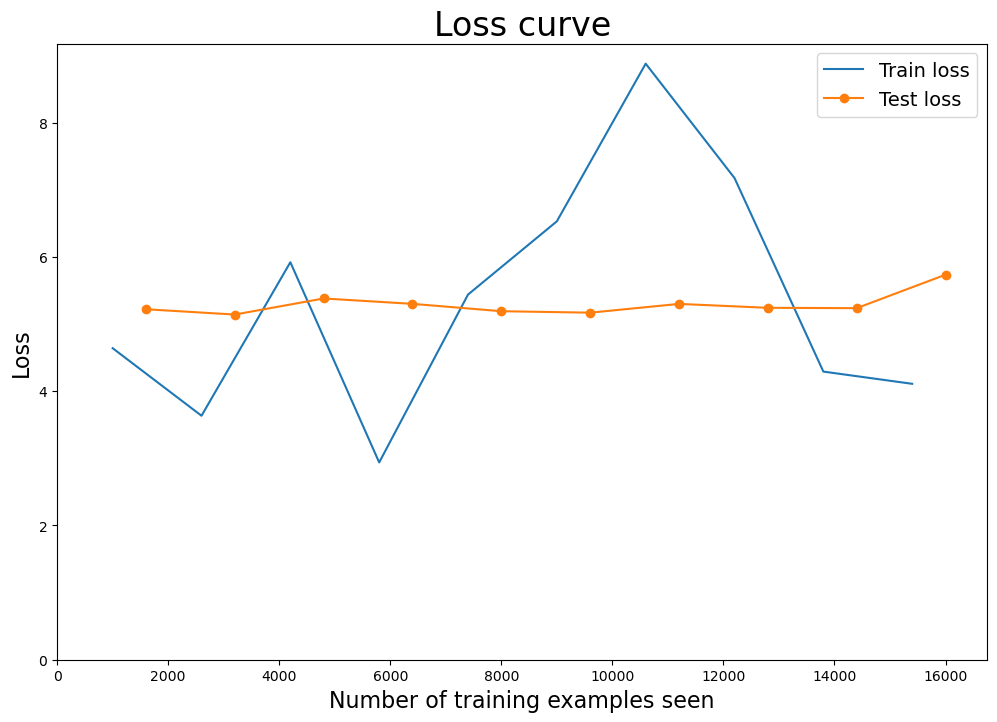

In [32]:
plt_loss_graph(train_loader, csr_train_counter, csr_train_losses, csr_test_losses)

In [33]:
report_metrics(train_loader, test_loader, csr_model, csr_criterion, DEVICE)

Training Set: Average loss: 0.5631, Accuracy: 33.94%
Test Set: Average loss: 0.5735, Accuracy: 34.00%


### 2. General CNN

In [34]:
cnn_model.to(DEVICE)
cnn_train_losses, cnn_train_counter, cnn_test_losses, cnn_test_correct = model_train(train_loader,
                                                                     test_loader, cnn_model, DEVICE, cnn_criterion, 
                                                                     cnn_optimizer, cnn_epochs, 5)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1], Step [1/160], Loss: 30.310373306274414
Epoch [1], Step [21/160], Loss: 4.355827808380127
Epoch [1], Step [41/160], Loss: 5.4006571769714355
Epoch [1], Step [61/160], Loss: 4.553067684173584
Epoch [1], Step [81/160], Loss: 2.245267629623413
Epoch [1], Step [101/160], Loss: 2.3666763305664062
Epoch [1], Step [121/160], Loss: 3.5590646266937256
Epoch [1], Step [141/160], Loss: 2.1364877223968506


Epochs:   2%|▏         | 1/50 [00:01<01:01,  1.26s/it]

Epoch [2], Step [1/160], Loss: 4.130523204803467
Epoch [2], Step [21/160], Loss: 3.3983848094940186
Epoch [2], Step [41/160], Loss: 2.001573085784912
Epoch [2], Step [61/160], Loss: 3.660912036895752
Epoch [2], Step [81/160], Loss: 1.7197760343551636
Epoch [2], Step [101/160], Loss: 1.5807833671569824
Epoch [2], Step [121/160], Loss: 1.528286099433899
Epoch [2], Step [141/160], Loss: 2.422079563140869


Epochs:   4%|▍         | 2/50 [00:02<01:00,  1.26s/it]

Epoch [3], Step [1/160], Loss: 2.8933587074279785
Epoch [3], Step [21/160], Loss: 5.590434551239014
Epoch [3], Step [41/160], Loss: 2.6812655925750732
Epoch [3], Step [61/160], Loss: 1.813736915588379
Epoch [3], Step [81/160], Loss: 2.8525750637054443
Epoch [3], Step [101/160], Loss: 2.2587087154388428
Epoch [3], Step [121/160], Loss: 4.352015972137451
Epoch [3], Step [141/160], Loss: 2.133871078491211


Epochs:   6%|▌         | 3/50 [00:03<00:59,  1.26s/it]

Epoch [4], Step [1/160], Loss: 2.2097175121307373
Epoch [4], Step [21/160], Loss: 2.9840965270996094
Epoch [4], Step [41/160], Loss: 1.4788917303085327
Epoch [4], Step [61/160], Loss: 2.1978485584259033
Epoch [4], Step [81/160], Loss: 2.7536208629608154
Epoch [4], Step [101/160], Loss: 2.8752174377441406
Epoch [4], Step [121/160], Loss: 1.959865927696228
Epoch [4], Step [141/160], Loss: 1.2323248386383057


Epochs:   8%|▊         | 4/50 [00:05<00:57,  1.26s/it]

Epoch [5], Step [1/160], Loss: 1.2053850889205933
Epoch [5], Step [21/160], Loss: 1.826300024986267
Epoch [5], Step [41/160], Loss: 1.5691829919815063
Epoch [5], Step [61/160], Loss: 1.7676613330841064
Epoch [5], Step [81/160], Loss: 5.58093786239624
Epoch [5], Step [101/160], Loss: 1.7672497034072876
Epoch [5], Step [121/160], Loss: 2.7644166946411133
Epoch [5], Step [141/160], Loss: 2.3406944274902344


Epochs:  10%|█         | 5/50 [00:06<00:56,  1.26s/it]

Epoch [6], Step [1/160], Loss: 5.462034702301025
Epoch [6], Step [21/160], Loss: 2.455070972442627
Epoch [6], Step [41/160], Loss: 2.8466193675994873
Epoch [6], Step [61/160], Loss: 2.9930100440979004
Epoch [6], Step [81/160], Loss: 0.7599963545799255
Epoch [6], Step [101/160], Loss: 1.7393916845321655
Epoch [6], Step [121/160], Loss: 2.9977633953094482
Epoch [6], Step [141/160], Loss: 2.2528574466705322


Epochs:  12%|█▏        | 6/50 [00:07<00:55,  1.26s/it]

Epoch [7], Step [1/160], Loss: 1.350981593132019
Epoch [7], Step [21/160], Loss: 1.3192123174667358
Epoch [7], Step [41/160], Loss: 1.4874082803726196
Epoch [7], Step [61/160], Loss: 1.986867904663086
Epoch [7], Step [81/160], Loss: 1.8685699701309204
Epoch [7], Step [101/160], Loss: 1.9996919631958008
Epoch [7], Step [121/160], Loss: 1.9319499731063843
Epoch [7], Step [141/160], Loss: 2.360525369644165


Epochs:  14%|█▍        | 7/50 [00:08<00:54,  1.26s/it]

Epoch [8], Step [1/160], Loss: 1.7289352416992188
Epoch [8], Step [21/160], Loss: 2.4184043407440186
Epoch [8], Step [41/160], Loss: 1.3106834888458252
Epoch [8], Step [61/160], Loss: 1.8997395038604736
Epoch [8], Step [81/160], Loss: 2.509953260421753
Epoch [8], Step [101/160], Loss: 1.9648350477218628
Epoch [8], Step [121/160], Loss: 1.5971450805664062
Epoch [8], Step [141/160], Loss: 3.1594924926757812


Epochs:  16%|█▌        | 8/50 [00:10<00:52,  1.26s/it]

Epoch [9], Step [1/160], Loss: 0.9063434600830078
Epoch [9], Step [21/160], Loss: 2.848716974258423
Epoch [9], Step [41/160], Loss: 1.570159673690796
Epoch [9], Step [61/160], Loss: 1.2533591985702515
Epoch [9], Step [81/160], Loss: 1.554334044456482
Epoch [9], Step [101/160], Loss: 0.8051528334617615
Epoch [9], Step [121/160], Loss: 0.9622451663017273
Epoch [9], Step [141/160], Loss: 2.0744130611419678


Epochs:  18%|█▊        | 9/50 [00:11<00:51,  1.26s/it]

Epoch [10], Step [1/160], Loss: 1.8477888107299805
Epoch [10], Step [21/160], Loss: 1.543323278427124
Epoch [10], Step [41/160], Loss: 1.171972632408142
Epoch [10], Step [61/160], Loss: 0.8068025708198547
Epoch [10], Step [81/160], Loss: 1.9825247526168823
Epoch [10], Step [101/160], Loss: 1.8941386938095093
Epoch [10], Step [121/160], Loss: 1.1333836317062378
Epoch [10], Step [141/160], Loss: 4.009881496429443


Epochs:  20%|██        | 10/50 [00:12<00:50,  1.27s/it]

Epoch [11], Step [1/160], Loss: 2.084829330444336
Epoch [11], Step [21/160], Loss: 2.0645225048065186
Epoch [11], Step [41/160], Loss: 1.7959206104278564
Epoch [11], Step [61/160], Loss: 1.8635088205337524
Epoch [11], Step [81/160], Loss: 1.537943720817566
Epoch [11], Step [101/160], Loss: 2.111354112625122
Epoch [11], Step [121/160], Loss: 1.0752805471420288
Epoch [11], Step [141/160], Loss: 1.2075560092926025


Epochs:  22%|██▏       | 11/50 [00:13<00:49,  1.27s/it]

Epoch [12], Step [1/160], Loss: 1.2091315984725952
Epoch [12], Step [21/160], Loss: 2.290520429611206
Epoch [12], Step [41/160], Loss: 1.1618261337280273
Epoch [12], Step [61/160], Loss: 1.4076179265975952
Epoch [12], Step [81/160], Loss: 1.3472471237182617
Epoch [12], Step [101/160], Loss: 1.4362291097640991
Epoch [12], Step [121/160], Loss: 3.5978660583496094
Epoch [12], Step [141/160], Loss: 1.397720217704773


Epochs:  24%|██▍       | 12/50 [00:15<00:48,  1.27s/it]

Epoch [13], Step [1/160], Loss: 1.275264859199524
Epoch [13], Step [21/160], Loss: 0.892558217048645
Epoch [13], Step [41/160], Loss: 1.6013988256454468
Epoch [13], Step [61/160], Loss: 1.5842870473861694
Epoch [13], Step [81/160], Loss: 0.8282546997070312
Epoch [13], Step [101/160], Loss: 1.360058069229126
Epoch [13], Step [121/160], Loss: 1.3512701988220215
Epoch [13], Step [141/160], Loss: 1.0816019773483276


Epochs:  26%|██▌       | 13/50 [00:16<00:47,  1.27s/it]

Epoch [14], Step [1/160], Loss: 1.8022778034210205
Epoch [14], Step [21/160], Loss: 0.758679211139679
Epoch [14], Step [41/160], Loss: 2.939765691757202
Epoch [14], Step [61/160], Loss: 1.564494013786316
Epoch [14], Step [81/160], Loss: 2.056648015975952
Epoch [14], Step [101/160], Loss: 1.5519827604293823
Epoch [14], Step [121/160], Loss: 0.6183151602745056
Epoch [14], Step [141/160], Loss: 1.1201995611190796


Epochs:  28%|██▊       | 14/50 [00:17<00:45,  1.27s/it]

Epoch [15], Step [1/160], Loss: 0.7476534843444824
Epoch [15], Step [21/160], Loss: 0.7757042646408081
Epoch [15], Step [41/160], Loss: 0.7267088294029236
Epoch [15], Step [61/160], Loss: 1.4239362478256226
Epoch [15], Step [81/160], Loss: 0.8669852614402771
Epoch [15], Step [101/160], Loss: 0.7054325342178345
Epoch [15], Step [121/160], Loss: 1.3104465007781982
Epoch [15], Step [141/160], Loss: 1.1034983396530151


Epochs:  30%|███       | 15/50 [00:18<00:44,  1.27s/it]

Epoch [16], Step [1/160], Loss: 1.2522400617599487
Epoch [16], Step [21/160], Loss: 0.9836826324462891
Epoch [16], Step [41/160], Loss: 1.8699569702148438
Epoch [16], Step [61/160], Loss: 2.734938144683838
Epoch [16], Step [81/160], Loss: 1.299581527709961
Epoch [16], Step [101/160], Loss: 2.292473077774048
Epoch [16], Step [121/160], Loss: 1.130014419555664
Epoch [16], Step [141/160], Loss: 1.2991224527359009


Epochs:  32%|███▏      | 16/50 [00:20<00:43,  1.27s/it]

Epoch [17], Step [1/160], Loss: 1.410811424255371
Epoch [17], Step [21/160], Loss: 0.7178672552108765
Epoch [17], Step [41/160], Loss: 0.5670610070228577
Epoch [17], Step [61/160], Loss: 1.9935327768325806
Epoch [17], Step [81/160], Loss: 0.9571385383605957
Epoch [17], Step [101/160], Loss: 1.4203308820724487
Epoch [17], Step [121/160], Loss: 0.9554649591445923
Epoch [17], Step [141/160], Loss: 1.4618806838989258


Epochs:  34%|███▍      | 17/50 [00:21<00:41,  1.26s/it]

Epoch [18], Step [1/160], Loss: 2.56669020652771
Epoch [18], Step [21/160], Loss: 0.9823741316795349
Epoch [18], Step [41/160], Loss: 0.9823114275932312
Epoch [18], Step [61/160], Loss: 1.1419459581375122
Epoch [18], Step [81/160], Loss: 2.471240758895874
Epoch [18], Step [101/160], Loss: 1.0982122421264648
Epoch [18], Step [121/160], Loss: 0.42829790711402893
Epoch [18], Step [141/160], Loss: 1.07297682762146


Epochs:  36%|███▌      | 18/50 [00:22<00:40,  1.26s/it]

Epoch [19], Step [1/160], Loss: 1.3643255233764648
Epoch [19], Step [21/160], Loss: 0.9527305960655212
Epoch [19], Step [41/160], Loss: 0.6422792673110962
Epoch [19], Step [61/160], Loss: 0.9486005902290344
Epoch [19], Step [81/160], Loss: 1.2005072832107544
Epoch [19], Step [101/160], Loss: 1.1753538846969604
Epoch [19], Step [121/160], Loss: 0.6543290019035339
Epoch [19], Step [141/160], Loss: 1.2153033018112183


Epochs:  38%|███▊      | 19/50 [00:23<00:38,  1.25s/it]

Epoch [20], Step [1/160], Loss: 0.6708652377128601
Epoch [20], Step [21/160], Loss: 1.1417597532272339
Epoch [20], Step [41/160], Loss: 1.5805250406265259
Epoch [20], Step [61/160], Loss: 1.494970679283142
Epoch [20], Step [81/160], Loss: 1.3249222040176392
Epoch [20], Step [101/160], Loss: 1.94338059425354
Epoch [20], Step [121/160], Loss: 1.165719985961914
Epoch [20], Step [141/160], Loss: 1.4086488485336304


Epochs:  40%|████      | 20/50 [00:25<00:37,  1.25s/it]

Epoch [21], Step [1/160], Loss: 0.4305865466594696
Epoch [21], Step [21/160], Loss: 1.2059082984924316
Epoch [21], Step [41/160], Loss: 0.8670862317085266
Epoch [21], Step [61/160], Loss: 1.041131854057312
Epoch [21], Step [81/160], Loss: 0.6407208442687988
Epoch [21], Step [101/160], Loss: 1.0537165403366089
Epoch [21], Step [121/160], Loss: 2.6458218097686768
Epoch [21], Step [141/160], Loss: 1.8829067945480347


Epochs:  42%|████▏     | 21/50 [00:26<00:36,  1.25s/it]

Epoch [22], Step [1/160], Loss: 2.4163787364959717
Epoch [22], Step [21/160], Loss: 0.8263446688652039
Epoch [22], Step [41/160], Loss: 1.3075226545333862
Epoch [22], Step [61/160], Loss: 0.5527689456939697
Epoch [22], Step [81/160], Loss: 1.5639276504516602
Epoch [22], Step [101/160], Loss: 0.37487462162971497
Epoch [22], Step [121/160], Loss: 2.9012956619262695
Epoch [22], Step [141/160], Loss: 2.3136706352233887


Epochs:  44%|████▍     | 22/50 [00:27<00:35,  1.25s/it]

Epoch [23], Step [1/160], Loss: 1.2498911619186401
Epoch [23], Step [21/160], Loss: 1.1721947193145752
Epoch [23], Step [41/160], Loss: 1.3584203720092773
Epoch [23], Step [61/160], Loss: 1.7137012481689453
Epoch [23], Step [81/160], Loss: 0.8219167590141296
Epoch [23], Step [101/160], Loss: 2.164778709411621
Epoch [23], Step [121/160], Loss: 1.4895544052124023
Epoch [23], Step [141/160], Loss: 1.2956809997558594


Epochs:  46%|████▌     | 23/50 [00:28<00:33,  1.25s/it]

Epoch [24], Step [1/160], Loss: 0.34901490807533264
Epoch [24], Step [21/160], Loss: 0.5866776704788208
Epoch [24], Step [41/160], Loss: 1.2477552890777588
Epoch [24], Step [61/160], Loss: 0.9709085822105408
Epoch [24], Step [81/160], Loss: 0.48274660110473633
Epoch [24], Step [101/160], Loss: 0.7913228869438171
Epoch [24], Step [121/160], Loss: 0.5975014567375183
Epoch [24], Step [141/160], Loss: 1.3437527418136597


Epochs:  48%|████▊     | 24/50 [00:30<00:32,  1.25s/it]

Epoch [25], Step [1/160], Loss: 1.4990954399108887
Epoch [25], Step [21/160], Loss: 0.6221811175346375
Epoch [25], Step [41/160], Loss: 1.4073565006256104
Epoch [25], Step [61/160], Loss: 0.7057607173919678
Epoch [25], Step [81/160], Loss: 0.5372964143753052
Epoch [25], Step [101/160], Loss: 1.0138758420944214
Epoch [25], Step [121/160], Loss: 0.5579083561897278
Epoch [25], Step [141/160], Loss: 1.3657734394073486


Epochs:  50%|█████     | 25/50 [00:31<00:31,  1.25s/it]

Epoch [26], Step [1/160], Loss: 0.726632833480835
Epoch [26], Step [21/160], Loss: 1.2681690454483032
Epoch [26], Step [41/160], Loss: 0.4016619622707367
Epoch [26], Step [61/160], Loss: 1.7312252521514893
Epoch [26], Step [81/160], Loss: 0.7086083292961121
Epoch [26], Step [101/160], Loss: 0.7141262292861938
Epoch [26], Step [121/160], Loss: 0.6011675000190735
Epoch [26], Step [141/160], Loss: 1.1862702369689941


Epochs:  52%|█████▏    | 26/50 [00:32<00:29,  1.25s/it]

Epoch [27], Step [1/160], Loss: 0.7102836966514587
Epoch [27], Step [21/160], Loss: 1.1906559467315674
Epoch [27], Step [41/160], Loss: 0.4149165749549866
Epoch [27], Step [61/160], Loss: 1.7930115461349487
Epoch [27], Step [81/160], Loss: 0.8253002166748047
Epoch [27], Step [101/160], Loss: 2.1310043334960938
Epoch [27], Step [121/160], Loss: 0.4727174937725067
Epoch [27], Step [141/160], Loss: 0.7063949108123779


Epochs:  54%|█████▍    | 27/50 [00:33<00:28,  1.25s/it]

Epoch [28], Step [1/160], Loss: 0.5007689595222473
Epoch [28], Step [21/160], Loss: 1.106122612953186
Epoch [28], Step [41/160], Loss: 0.4532845616340637
Epoch [28], Step [61/160], Loss: 0.5220419764518738
Epoch [28], Step [81/160], Loss: 1.1958297491073608
Epoch [28], Step [101/160], Loss: 0.3349943161010742
Epoch [28], Step [121/160], Loss: 1.0165302753448486
Epoch [28], Step [141/160], Loss: 0.9282385110855103


Epochs:  56%|█████▌    | 28/50 [00:35<00:27,  1.24s/it]

Epoch [29], Step [1/160], Loss: 0.578223705291748
Epoch [29], Step [21/160], Loss: 0.4058457016944885
Epoch [29], Step [41/160], Loss: 1.0911706686019897
Epoch [29], Step [61/160], Loss: 0.5477928519248962
Epoch [29], Step [81/160], Loss: 1.5681064128875732
Epoch [29], Step [101/160], Loss: 1.3705638647079468
Epoch [29], Step [121/160], Loss: 1.459290623664856
Epoch [29], Step [141/160], Loss: 1.0141500234603882


Epochs:  58%|█████▊    | 29/50 [00:36<00:26,  1.24s/it]

Epoch [30], Step [1/160], Loss: 0.4687536656856537
Epoch [30], Step [21/160], Loss: 0.7450917959213257
Epoch [30], Step [41/160], Loss: 0.4519805908203125
Epoch [30], Step [61/160], Loss: 0.8433049321174622
Epoch [30], Step [81/160], Loss: 0.5088474154472351
Epoch [30], Step [101/160], Loss: 0.8846611976623535
Epoch [30], Step [121/160], Loss: 0.7683599591255188
Epoch [30], Step [141/160], Loss: 0.8801471590995789


Epochs:  60%|██████    | 30/50 [00:37<00:24,  1.25s/it]

Epoch [31], Step [1/160], Loss: 0.5644243359565735
Epoch [31], Step [21/160], Loss: 0.9901806116104126
Epoch [31], Step [41/160], Loss: 1.0989922285079956
Epoch [31], Step [61/160], Loss: 0.29017171263694763
Epoch [31], Step [81/160], Loss: 1.2865246534347534
Epoch [31], Step [101/160], Loss: 0.9998357892036438
Epoch [31], Step [121/160], Loss: 0.4868679940700531
Epoch [31], Step [141/160], Loss: 0.6732231378555298


Epochs:  62%|██████▏   | 31/50 [00:38<00:23,  1.24s/it]

Epoch [32], Step [1/160], Loss: 0.6349478960037231
Epoch [32], Step [21/160], Loss: 1.2165930271148682
Epoch [32], Step [41/160], Loss: 1.305119514465332
Epoch [32], Step [61/160], Loss: 0.351158082485199
Epoch [32], Step [81/160], Loss: 1.251159906387329
Epoch [32], Step [101/160], Loss: 0.5819384455680847
Epoch [32], Step [121/160], Loss: 0.44353681802749634
Epoch [32], Step [141/160], Loss: 0.4368797242641449


Epochs:  64%|██████▍   | 32/50 [00:40<00:22,  1.24s/it]

Epoch [33], Step [1/160], Loss: 2.019930124282837
Epoch [33], Step [21/160], Loss: 0.5938059091567993
Epoch [33], Step [41/160], Loss: 1.09642493724823
Epoch [33], Step [61/160], Loss: 0.3487967550754547
Epoch [33], Step [81/160], Loss: 0.47920486330986023
Epoch [33], Step [101/160], Loss: 1.0189942121505737
Epoch [33], Step [121/160], Loss: 0.968804657459259
Epoch [33], Step [141/160], Loss: 1.616403579711914


Epochs:  66%|██████▌   | 33/50 [00:41<00:21,  1.24s/it]

Epoch [34], Step [1/160], Loss: 1.5933212041854858
Epoch [34], Step [21/160], Loss: 0.4389006793498993
Epoch [34], Step [41/160], Loss: 0.557625949382782
Epoch [34], Step [61/160], Loss: 0.9500043988227844
Epoch [34], Step [81/160], Loss: 0.9548935294151306
Epoch [34], Step [101/160], Loss: 0.5048527121543884
Epoch [34], Step [121/160], Loss: 0.23525257408618927
Epoch [34], Step [141/160], Loss: 0.5858942866325378


Epochs:  68%|██████▊   | 34/50 [00:42<00:19,  1.24s/it]

Epoch [35], Step [1/160], Loss: 1.2514241933822632
Epoch [35], Step [21/160], Loss: 0.8794978260993958
Epoch [35], Step [41/160], Loss: 0.7463764548301697
Epoch [35], Step [61/160], Loss: 1.065447449684143
Epoch [35], Step [81/160], Loss: 0.954511284828186
Epoch [35], Step [101/160], Loss: 1.3090566396713257
Epoch [35], Step [121/160], Loss: 1.9521557092666626
Epoch [35], Step [141/160], Loss: 0.47078782320022583


Epochs:  70%|███████   | 35/50 [00:43<00:18,  1.24s/it]

Epoch [36], Step [1/160], Loss: 0.5179271101951599
Epoch [36], Step [21/160], Loss: 0.6608185172080994
Epoch [36], Step [41/160], Loss: 0.504706859588623
Epoch [36], Step [61/160], Loss: 0.8415793776512146
Epoch [36], Step [81/160], Loss: 1.2697951793670654
Epoch [36], Step [101/160], Loss: 0.4408450126647949
Epoch [36], Step [121/160], Loss: 0.43210920691490173
Epoch [36], Step [141/160], Loss: 0.7963005900382996


Epochs:  72%|███████▏  | 36/50 [00:45<00:17,  1.24s/it]

Epoch [37], Step [1/160], Loss: 0.5415381193161011
Epoch [37], Step [21/160], Loss: 0.6721283793449402
Epoch [37], Step [41/160], Loss: 0.3459297716617584
Epoch [37], Step [61/160], Loss: 0.22342820465564728
Epoch [37], Step [81/160], Loss: 1.070089340209961
Epoch [37], Step [101/160], Loss: 0.6959673762321472
Epoch [37], Step [121/160], Loss: 1.0522669553756714
Epoch [37], Step [141/160], Loss: 0.9496306777000427


Epochs:  74%|███████▍  | 37/50 [00:46<00:16,  1.24s/it]

Epoch [38], Step [1/160], Loss: 0.607456386089325
Epoch [38], Step [21/160], Loss: 1.0045799016952515
Epoch [38], Step [41/160], Loss: 0.6101900339126587
Epoch [38], Step [61/160], Loss: 1.2334057092666626
Epoch [38], Step [81/160], Loss: 0.7770141959190369
Epoch [38], Step [101/160], Loss: 1.1010897159576416
Epoch [38], Step [121/160], Loss: 1.1757806539535522
Epoch [38], Step [141/160], Loss: 0.38264554738998413


Epochs:  76%|███████▌  | 38/50 [00:47<00:14,  1.24s/it]

Epoch [39], Step [1/160], Loss: 1.1904720067977905
Epoch [39], Step [21/160], Loss: 0.7046558260917664
Epoch [39], Step [41/160], Loss: 0.5498977899551392
Epoch [39], Step [61/160], Loss: 0.51927250623703
Epoch [39], Step [81/160], Loss: 0.7838100790977478
Epoch [39], Step [101/160], Loss: 0.6893249750137329
Epoch [39], Step [121/160], Loss: 0.7937657237052917
Epoch [39], Step [141/160], Loss: 0.772609531879425


Epochs:  78%|███████▊  | 39/50 [00:48<00:13,  1.24s/it]

Epoch [40], Step [1/160], Loss: 0.8867962956428528
Epoch [40], Step [21/160], Loss: 0.39876458048820496
Epoch [40], Step [41/160], Loss: 0.9779111742973328
Epoch [40], Step [61/160], Loss: 0.47429656982421875
Epoch [40], Step [81/160], Loss: 0.4844001233577728
Epoch [40], Step [101/160], Loss: 0.928584098815918
Epoch [40], Step [121/160], Loss: 0.34461531043052673
Epoch [40], Step [141/160], Loss: 0.2608029544353485


Epochs:  80%|████████  | 40/50 [00:50<00:12,  1.25s/it]

Epoch [41], Step [1/160], Loss: 0.8416339159011841
Epoch [41], Step [21/160], Loss: 1.02499520778656
Epoch [41], Step [41/160], Loss: 0.7697409987449646
Epoch [41], Step [61/160], Loss: 0.3112514913082123
Epoch [41], Step [81/160], Loss: 0.32350945472717285
Epoch [41], Step [101/160], Loss: 0.591202437877655
Epoch [41], Step [121/160], Loss: 0.47367793321609497
Epoch [41], Step [141/160], Loss: 1.0303444862365723


Epochs:  82%|████████▏ | 41/50 [00:51<00:11,  1.25s/it]

Epoch [42], Step [1/160], Loss: 0.48069411516189575
Epoch [42], Step [21/160], Loss: 0.24748079478740692
Epoch [42], Step [41/160], Loss: 0.4499809443950653
Epoch [42], Step [61/160], Loss: 1.1883854866027832
Epoch [42], Step [81/160], Loss: 0.5163806676864624
Epoch [42], Step [101/160], Loss: 0.317148357629776
Epoch [42], Step [121/160], Loss: 0.3078255355358124
Epoch [42], Step [141/160], Loss: 0.7963610887527466


Epochs:  84%|████████▍ | 42/50 [00:52<00:09,  1.25s/it]

Epoch [43], Step [1/160], Loss: 0.34306201338768005
Epoch [43], Step [21/160], Loss: 0.630763828754425
Epoch [43], Step [41/160], Loss: 0.3482845425605774
Epoch [43], Step [61/160], Loss: 1.0164598226547241
Epoch [43], Step [81/160], Loss: 0.5722936391830444
Epoch [43], Step [101/160], Loss: 0.6240038871765137
Epoch [43], Step [121/160], Loss: 1.3394956588745117
Epoch [43], Step [141/160], Loss: 0.8106134533882141


Epochs:  86%|████████▌ | 43/50 [00:53<00:08,  1.25s/it]

Epoch [44], Step [1/160], Loss: 0.8249780535697937
Epoch [44], Step [21/160], Loss: 0.5161470770835876
Epoch [44], Step [41/160], Loss: 0.8388064503669739
Epoch [44], Step [61/160], Loss: 0.5701399445533752
Epoch [44], Step [81/160], Loss: 1.0582009553909302
Epoch [44], Step [101/160], Loss: 0.26502686738967896
Epoch [44], Step [121/160], Loss: 0.7547768950462341
Epoch [44], Step [141/160], Loss: 0.3449227809906006


Epochs:  88%|████████▊ | 44/50 [00:55<00:07,  1.25s/it]

Epoch [45], Step [1/160], Loss: 0.5758253931999207
Epoch [45], Step [21/160], Loss: 0.8390474319458008
Epoch [45], Step [41/160], Loss: 0.6684629321098328
Epoch [45], Step [61/160], Loss: 0.7035753130912781
Epoch [45], Step [81/160], Loss: 1.3637694120407104
Epoch [45], Step [101/160], Loss: 0.30050382018089294
Epoch [45], Step [121/160], Loss: 0.5857797265052795
Epoch [45], Step [141/160], Loss: 0.6146306991577148


Epochs:  90%|█████████ | 45/50 [00:56<00:06,  1.25s/it]

Epoch [46], Step [1/160], Loss: 0.3967641592025757
Epoch [46], Step [21/160], Loss: 0.28710436820983887
Epoch [46], Step [41/160], Loss: 0.6612667441368103
Epoch [46], Step [61/160], Loss: 0.6292857527732849
Epoch [46], Step [81/160], Loss: 0.30950674414634705
Epoch [46], Step [101/160], Loss: 0.522014319896698
Epoch [46], Step [121/160], Loss: 0.6229565739631653
Epoch [46], Step [141/160], Loss: 0.598604142665863


Epochs:  92%|█████████▏| 46/50 [00:57<00:05,  1.25s/it]

Epoch [47], Step [1/160], Loss: 0.5642114877700806
Epoch [47], Step [21/160], Loss: 0.4035871624946594
Epoch [47], Step [41/160], Loss: 0.5708837509155273
Epoch [47], Step [61/160], Loss: 0.17012886703014374
Epoch [47], Step [81/160], Loss: 0.5199670195579529
Epoch [47], Step [101/160], Loss: 0.5969827771186829
Epoch [47], Step [121/160], Loss: 0.5780355334281921
Epoch [47], Step [141/160], Loss: 0.5993682146072388


Epochs:  94%|█████████▍| 47/50 [00:58<00:03,  1.25s/it]

Epoch [48], Step [1/160], Loss: 0.7505068182945251
Epoch [48], Step [21/160], Loss: 0.5905093550682068
Epoch [48], Step [41/160], Loss: 0.3528054356575012
Epoch [48], Step [61/160], Loss: 0.45858678221702576
Epoch [48], Step [81/160], Loss: 0.12746155261993408
Epoch [48], Step [101/160], Loss: 0.6744433045387268
Epoch [48], Step [121/160], Loss: 0.6675379872322083
Epoch [48], Step [141/160], Loss: 0.49015894532203674


Epochs:  96%|█████████▌| 48/50 [01:00<00:02,  1.24s/it]

Epoch [49], Step [1/160], Loss: 1.3013092279434204
Epoch [49], Step [21/160], Loss: 0.27035436034202576
Epoch [49], Step [41/160], Loss: 0.15607577562332153
Epoch [49], Step [61/160], Loss: 0.3908320367336273
Epoch [49], Step [81/160], Loss: 1.4568984508514404
Epoch [49], Step [101/160], Loss: 0.4380989968776703
Epoch [49], Step [121/160], Loss: 0.9517607688903809
Epoch [49], Step [141/160], Loss: 0.8064188361167908


Epochs:  98%|█████████▊| 49/50 [01:01<00:01,  1.24s/it]

Epoch [50], Step [1/160], Loss: 0.29302331805229187
Epoch [50], Step [21/160], Loss: 0.19364844262599945
Epoch [50], Step [41/160], Loss: 0.2987959682941437
Epoch [50], Step [61/160], Loss: 0.38513144850730896
Epoch [50], Step [81/160], Loss: 0.3197304308414459
Epoch [50], Step [101/160], Loss: 0.5774537920951843
Epoch [50], Step [121/160], Loss: 0.770815372467041
Epoch [50], Step [141/160], Loss: 0.6520342826843262


Epochs: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


Test accuracy: 0.1825


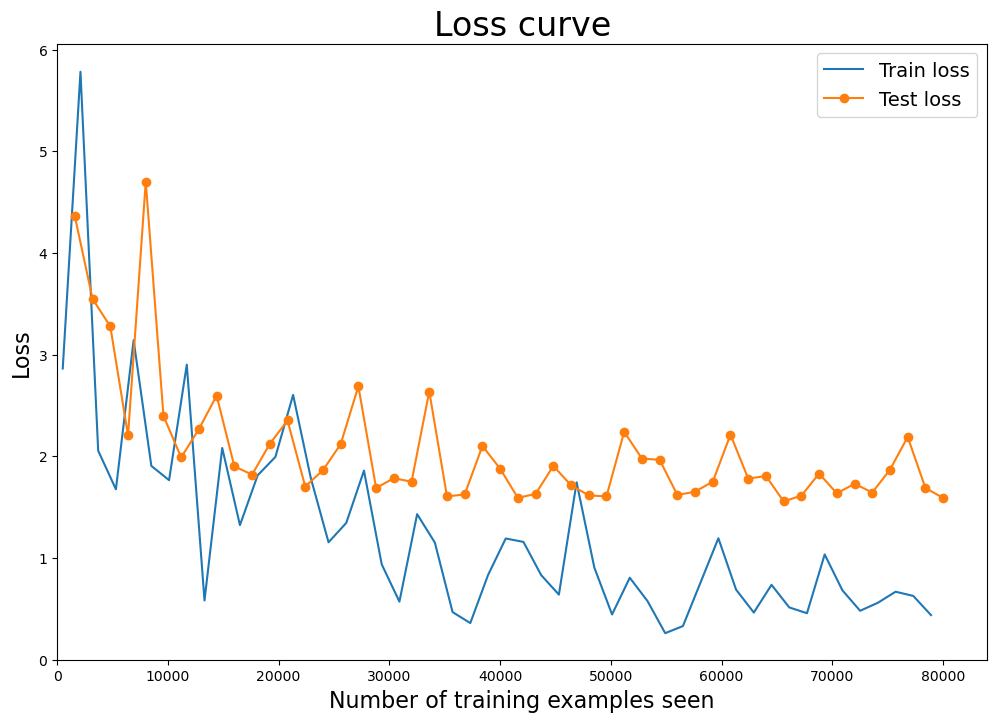

In [35]:
plt_loss_graph(train_loader, cnn_train_counter, cnn_train_losses, cnn_test_losses)

In [36]:
report_metrics(train_loader, test_loader, cnn_model, cnn_criterion, DEVICE)

Training Set: Average loss: 0.0490, Accuracy: 98.12%
Test Set: Average loss: 0.1591, Accuracy: 79.25%


### 3. Mobile Net

In [37]:
mobile_net_model.to(DEVICE)
mobile_net_train_losses, mobile_net_train_counter, mobile_net_test_losses, mobile_net_test_correct = model_train(train_loader,
                                                                     test_loader, mobile_net_model, DEVICE, mobile_net_criterion, 
                                                                     mobile_net_optimizer, mobile_net_epochs, 5)

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch [1], Step [1/160], Loss: 1259.03125
Epoch [1], Step [21/160], Loss: 22.058460235595703
Epoch [1], Step [41/160], Loss: 16.6246395111084
Epoch [1], Step [61/160], Loss: 15.375693321228027
Epoch [1], Step [81/160], Loss: 7.927680492401123
Epoch [1], Step [101/160], Loss: 11.196745872497559
Epoch [1], Step [121/160], Loss: 15.566313743591309
Epoch [1], Step [141/160], Loss: 30.386600494384766


Epochs:   1%|▏         | 1/70 [00:03<04:22,  3.81s/it]

Epoch [2], Step [1/160], Loss: 3.7820606231689453
Epoch [2], Step [21/160], Loss: 5.456070899963379
Epoch [2], Step [41/160], Loss: 6.432461738586426
Epoch [2], Step [61/160], Loss: 4.261868476867676
Epoch [2], Step [81/160], Loss: 6.492366313934326
Epoch [2], Step [101/160], Loss: 8.969696044921875
Epoch [2], Step [121/160], Loss: 6.021459102630615
Epoch [2], Step [141/160], Loss: 16.37000846862793


Epochs:   3%|▎         | 2/70 [00:07<04:11,  3.70s/it]

Epoch [3], Step [1/160], Loss: 1.8789833784103394
Epoch [3], Step [21/160], Loss: 17.03270721435547
Epoch [3], Step [41/160], Loss: 6.461087226867676
Epoch [3], Step [61/160], Loss: 3.5257766246795654
Epoch [3], Step [81/160], Loss: 2.890049457550049
Epoch [3], Step [101/160], Loss: 22.25990867614746
Epoch [3], Step [121/160], Loss: 3.797954559326172
Epoch [3], Step [141/160], Loss: 12.23920726776123


Epochs:   4%|▍         | 3/70 [00:11<04:17,  3.85s/it]

Epoch [4], Step [1/160], Loss: 34.46101760864258
Epoch [4], Step [21/160], Loss: 19.675294876098633
Epoch [4], Step [41/160], Loss: 23.475881576538086
Epoch [4], Step [61/160], Loss: 4.118598937988281
Epoch [4], Step [81/160], Loss: 2.246657371520996
Epoch [4], Step [101/160], Loss: 3.4558961391448975
Epoch [4], Step [121/160], Loss: 12.243962287902832
Epoch [4], Step [141/160], Loss: 9.408434867858887


Epochs:   6%|▌         | 4/70 [00:15<04:18,  3.92s/it]

Epoch [5], Step [1/160], Loss: 4.99101448059082
Epoch [5], Step [21/160], Loss: 10.497133255004883
Epoch [5], Step [41/160], Loss: 5.398613929748535
Epoch [5], Step [61/160], Loss: 3.7972514629364014
Epoch [5], Step [81/160], Loss: 2.9655163288116455
Epoch [5], Step [101/160], Loss: 8.293681144714355
Epoch [5], Step [121/160], Loss: 18.381256103515625
Epoch [5], Step [141/160], Loss: 8.844490051269531


Epochs:   7%|▋         | 5/70 [00:19<04:14,  3.92s/it]

Epoch [6], Step [1/160], Loss: 36.629127502441406
Epoch [6], Step [21/160], Loss: 36.611351013183594
Epoch [6], Step [41/160], Loss: 3.951866865158081
Epoch [6], Step [61/160], Loss: 14.296249389648438
Epoch [6], Step [81/160], Loss: 5.048543453216553
Epoch [6], Step [101/160], Loss: 2.700143814086914
Epoch [6], Step [121/160], Loss: 2.7905638217926025
Epoch [6], Step [141/160], Loss: 6.748693943023682


Epochs:   9%|▊         | 6/70 [00:23<04:07,  3.86s/it]

Epoch [7], Step [1/160], Loss: 8.927258491516113
Epoch [7], Step [21/160], Loss: 6.253539562225342
Epoch [7], Step [41/160], Loss: 3.7038371562957764
Epoch [7], Step [61/160], Loss: 5.18958044052124
Epoch [7], Step [81/160], Loss: 16.272199630737305
Epoch [7], Step [101/160], Loss: 3.297300100326538
Epoch [7], Step [121/160], Loss: 7.836109161376953
Epoch [7], Step [141/160], Loss: 8.583000183105469


Epochs:  10%|█         | 7/70 [00:26<03:58,  3.79s/it]

Epoch [8], Step [1/160], Loss: 18.741943359375
Epoch [8], Step [21/160], Loss: 5.477794170379639
Epoch [8], Step [41/160], Loss: 4.440418720245361
Epoch [8], Step [61/160], Loss: 2.832463026046753
Epoch [8], Step [81/160], Loss: 5.866576671600342
Epoch [8], Step [101/160], Loss: 12.91337776184082
Epoch [8], Step [121/160], Loss: 4.740043640136719
Epoch [8], Step [141/160], Loss: 10.804327964782715


Epochs:  11%|█▏        | 8/70 [00:30<03:57,  3.83s/it]

Epoch [9], Step [1/160], Loss: 1.6837562322616577
Epoch [9], Step [21/160], Loss: 7.926258087158203
Epoch [9], Step [41/160], Loss: 6.275649070739746
Epoch [9], Step [61/160], Loss: 9.823041915893555
Epoch [9], Step [81/160], Loss: 12.255373001098633
Epoch [9], Step [101/160], Loss: 19.09956169128418
Epoch [9], Step [121/160], Loss: 9.966757774353027
Epoch [9], Step [141/160], Loss: 5.054621696472168


Epochs:  13%|█▎        | 9/70 [00:34<03:55,  3.86s/it]

Epoch [10], Step [1/160], Loss: 1.9270973205566406
Epoch [10], Step [21/160], Loss: 2.9352128505706787
Epoch [10], Step [41/160], Loss: 6.76989221572876
Epoch [10], Step [61/160], Loss: 7.906314849853516
Epoch [10], Step [81/160], Loss: 6.77432107925415
Epoch [10], Step [101/160], Loss: 9.199956893920898
Epoch [10], Step [121/160], Loss: 2.5094518661499023
Epoch [10], Step [141/160], Loss: 2.3510894775390625


Epochs:  14%|█▍        | 10/70 [00:38<03:45,  3.77s/it]

Epoch [11], Step [1/160], Loss: 3.3100533485412598
Epoch [11], Step [21/160], Loss: 4.468467712402344
Epoch [11], Step [41/160], Loss: 2.2950589656829834
Epoch [11], Step [61/160], Loss: 15.292712211608887
Epoch [11], Step [81/160], Loss: 6.6721930503845215
Epoch [11], Step [101/160], Loss: 3.6451187133789062
Epoch [11], Step [121/160], Loss: 1.8040350675582886
Epoch [11], Step [141/160], Loss: 3.685603380203247


Epochs:  16%|█▌        | 11/70 [00:41<03:38,  3.70s/it]

Epoch [12], Step [1/160], Loss: 5.7666707038879395
Epoch [12], Step [21/160], Loss: 8.651251792907715
Epoch [12], Step [41/160], Loss: 2.5254390239715576
Epoch [12], Step [61/160], Loss: 2.6826720237731934
Epoch [12], Step [81/160], Loss: 2.9354054927825928
Epoch [12], Step [101/160], Loss: 2.8301520347595215
Epoch [12], Step [121/160], Loss: 13.587488174438477
Epoch [12], Step [141/160], Loss: 2.0336344242095947


Epochs:  17%|█▋        | 12/70 [00:45<03:32,  3.66s/it]

Epoch [13], Step [1/160], Loss: 2.1558327674865723
Epoch [13], Step [21/160], Loss: 2.2924396991729736
Epoch [13], Step [41/160], Loss: 2.306178092956543
Epoch [13], Step [61/160], Loss: 6.459558963775635
Epoch [13], Step [81/160], Loss: 3.399442434310913
Epoch [13], Step [101/160], Loss: 6.688870429992676
Epoch [13], Step [121/160], Loss: 3.167898654937744
Epoch [13], Step [141/160], Loss: 12.069398880004883


Epochs:  19%|█▊        | 13/70 [00:48<03:27,  3.65s/it]

Epoch [14], Step [1/160], Loss: 3.766188859939575
Epoch [14], Step [21/160], Loss: 8.427882194519043
Epoch [14], Step [41/160], Loss: 33.80941390991211
Epoch [14], Step [61/160], Loss: 5.24947452545166
Epoch [14], Step [81/160], Loss: 6.468512058258057
Epoch [14], Step [101/160], Loss: 4.488579273223877
Epoch [14], Step [121/160], Loss: 4.406310081481934
Epoch [14], Step [141/160], Loss: 6.643819332122803


Epochs:  20%|██        | 14/70 [00:52<03:25,  3.67s/it]

Epoch [15], Step [1/160], Loss: 1.6934174299240112
Epoch [15], Step [21/160], Loss: 2.7679696083068848
Epoch [15], Step [41/160], Loss: 4.042575359344482
Epoch [15], Step [61/160], Loss: 2.5222389698028564
Epoch [15], Step [81/160], Loss: 0.7107899785041809
Epoch [15], Step [101/160], Loss: 4.155484199523926
Epoch [15], Step [121/160], Loss: 3.1243515014648438
Epoch [15], Step [141/160], Loss: 1.8634766340255737


Epochs:  21%|██▏       | 15/70 [00:56<03:22,  3.68s/it]

Epoch [16], Step [1/160], Loss: 1.5427603721618652
Epoch [16], Step [21/160], Loss: 3.0429601669311523
Epoch [16], Step [41/160], Loss: 4.798457622528076
Epoch [16], Step [61/160], Loss: 7.2715163230896
Epoch [16], Step [81/160], Loss: 2.8085837364196777
Epoch [16], Step [101/160], Loss: 5.471863746643066
Epoch [16], Step [121/160], Loss: 3.63962721824646
Epoch [16], Step [141/160], Loss: 1.7605476379394531


Epochs:  23%|██▎       | 16/70 [01:00<03:19,  3.70s/it]

Epoch [17], Step [1/160], Loss: 5.547982215881348
Epoch [17], Step [21/160], Loss: 0.9674415588378906
Epoch [17], Step [41/160], Loss: 5.379234313964844
Epoch [17], Step [61/160], Loss: 2.627476930618286
Epoch [17], Step [81/160], Loss: 14.750960350036621
Epoch [17], Step [101/160], Loss: 5.645110607147217
Epoch [17], Step [121/160], Loss: 2.2406201362609863
Epoch [17], Step [141/160], Loss: 2.602060079574585


Epochs:  24%|██▍       | 17/70 [01:03<03:14,  3.66s/it]

Epoch [18], Step [1/160], Loss: 2.3814103603363037
Epoch [18], Step [21/160], Loss: 0.4757477939128876
Epoch [18], Step [41/160], Loss: 1.616564393043518
Epoch [18], Step [61/160], Loss: 2.198760986328125
Epoch [18], Step [81/160], Loss: 2.4535980224609375
Epoch [18], Step [101/160], Loss: 0.7018389105796814
Epoch [18], Step [121/160], Loss: 2.3605618476867676
Epoch [18], Step [141/160], Loss: 2.5219242572784424


Epochs:  26%|██▌       | 18/70 [01:07<03:11,  3.68s/it]

Epoch [19], Step [1/160], Loss: 1.8634175062179565
Epoch [19], Step [21/160], Loss: 4.955307483673096
Epoch [19], Step [41/160], Loss: 4.379336833953857
Epoch [19], Step [61/160], Loss: 0.9658879637718201
Epoch [19], Step [81/160], Loss: 2.866741180419922
Epoch [19], Step [101/160], Loss: 0.7057322263717651
Epoch [19], Step [121/160], Loss: 7.5070977210998535
Epoch [19], Step [141/160], Loss: 1.8786710500717163


Epochs:  27%|██▋       | 19/70 [01:11<03:07,  3.68s/it]

Epoch [20], Step [1/160], Loss: 1.6678228378295898
Epoch [20], Step [21/160], Loss: 4.087162017822266
Epoch [20], Step [41/160], Loss: 3.305669069290161
Epoch [20], Step [61/160], Loss: 0.5433114767074585
Epoch [20], Step [81/160], Loss: 1.621848702430725
Epoch [20], Step [101/160], Loss: 2.3358941078186035
Epoch [20], Step [121/160], Loss: 5.467896461486816
Epoch [20], Step [141/160], Loss: 4.9798665046691895


Epochs:  29%|██▊       | 20/70 [01:14<03:03,  3.67s/it]

Epoch [21], Step [1/160], Loss: 2.468475103378296
Epoch [21], Step [21/160], Loss: 1.4846081733703613
Epoch [21], Step [41/160], Loss: 4.1352410316467285
Epoch [21], Step [61/160], Loss: 1.621258020401001
Epoch [21], Step [81/160], Loss: 4.418722152709961
Epoch [21], Step [101/160], Loss: 1.5387450456619263
Epoch [21], Step [121/160], Loss: 2.973358631134033
Epoch [21], Step [141/160], Loss: 2.872694253921509


Epochs:  30%|███       | 21/70 [01:18<02:57,  3.63s/it]

Epoch [22], Step [1/160], Loss: 4.065270900726318
Epoch [22], Step [21/160], Loss: 7.653558254241943
Epoch [22], Step [41/160], Loss: 7.604640483856201
Epoch [22], Step [61/160], Loss: 2.258809804916382
Epoch [22], Step [81/160], Loss: 3.9511520862579346
Epoch [22], Step [101/160], Loss: 1.4530316591262817
Epoch [22], Step [121/160], Loss: 6.230334758758545
Epoch [22], Step [141/160], Loss: 4.065978527069092


Epochs:  31%|███▏      | 22/70 [01:21<02:53,  3.61s/it]

Epoch [23], Step [1/160], Loss: 3.727529287338257
Epoch [23], Step [21/160], Loss: 4.713885307312012
Epoch [23], Step [41/160], Loss: 2.205753803253174
Epoch [23], Step [61/160], Loss: 1.442931056022644
Epoch [23], Step [81/160], Loss: 1.2508188486099243
Epoch [23], Step [101/160], Loss: 3.4461472034454346
Epoch [23], Step [121/160], Loss: 5.406829833984375
Epoch [23], Step [141/160], Loss: 1.9650455713272095


Epochs:  33%|███▎      | 23/70 [01:25<02:48,  3.59s/it]

Epoch [24], Step [1/160], Loss: 1.8744966983795166
Epoch [24], Step [21/160], Loss: 4.863991737365723
Epoch [24], Step [41/160], Loss: 2.241814374923706
Epoch [24], Step [61/160], Loss: 3.5256431102752686
Epoch [24], Step [81/160], Loss: 3.544984817504883
Epoch [24], Step [101/160], Loss: 1.735472321510315
Epoch [24], Step [121/160], Loss: 5.686717510223389
Epoch [24], Step [141/160], Loss: 2.6062324047088623


Epochs:  34%|███▍      | 24/70 [01:28<02:45,  3.59s/it]

Epoch [25], Step [1/160], Loss: 2.247770309448242
Epoch [25], Step [21/160], Loss: 3.4248597621917725
Epoch [25], Step [41/160], Loss: 1.4428553581237793
Epoch [25], Step [61/160], Loss: 2.750706434249878
Epoch [25], Step [81/160], Loss: 4.204457759857178
Epoch [25], Step [101/160], Loss: 1.984192132949829
Epoch [25], Step [121/160], Loss: 2.6981399059295654
Epoch [25], Step [141/160], Loss: 2.8085014820098877


Epochs:  36%|███▌      | 25/70 [01:32<02:41,  3.58s/it]

Epoch [26], Step [1/160], Loss: 2.6299526691436768
Epoch [26], Step [21/160], Loss: 3.8737952709198
Epoch [26], Step [41/160], Loss: 1.5416048765182495
Epoch [26], Step [61/160], Loss: 2.658360242843628
Epoch [26], Step [81/160], Loss: 0.9342174530029297
Epoch [26], Step [101/160], Loss: 1.812756896018982
Epoch [26], Step [121/160], Loss: 6.068747043609619
Epoch [26], Step [141/160], Loss: 1.6569973230361938


Epochs:  37%|███▋      | 26/70 [01:36<02:38,  3.61s/it]

Epoch [27], Step [1/160], Loss: 1.8494453430175781
Epoch [27], Step [21/160], Loss: 2.4896976947784424
Epoch [27], Step [41/160], Loss: 3.095947504043579
Epoch [27], Step [61/160], Loss: 0.8400114178657532
Epoch [27], Step [81/160], Loss: 2.2960102558135986
Epoch [27], Step [101/160], Loss: 5.40961217880249
Epoch [27], Step [121/160], Loss: 1.58147394657135
Epoch [27], Step [141/160], Loss: 0.6285080313682556


Epochs:  39%|███▊      | 27/70 [01:39<02:34,  3.59s/it]

Epoch [28], Step [1/160], Loss: 1.9102106094360352
Epoch [28], Step [21/160], Loss: 2.7450571060180664
Epoch [28], Step [41/160], Loss: 7.098609447479248
Epoch [28], Step [61/160], Loss: 9.20026969909668
Epoch [28], Step [81/160], Loss: 1.7053149938583374
Epoch [28], Step [101/160], Loss: 1.6753196716308594
Epoch [28], Step [121/160], Loss: 3.5294747352600098
Epoch [28], Step [141/160], Loss: 0.524641215801239


Epochs:  40%|████      | 28/70 [01:43<02:32,  3.62s/it]

Epoch [29], Step [1/160], Loss: 5.156023979187012
Epoch [29], Step [21/160], Loss: 1.6930946111679077
Epoch [29], Step [41/160], Loss: 3.080878734588623
Epoch [29], Step [61/160], Loss: 13.277043342590332
Epoch [29], Step [81/160], Loss: 5.760634422302246
Epoch [29], Step [101/160], Loss: 2.7000513076782227
Epoch [29], Step [121/160], Loss: 1.9569710493087769
Epoch [29], Step [141/160], Loss: 0.6359078288078308


Epochs:  41%|████▏     | 29/70 [01:46<02:27,  3.59s/it]

Epoch [30], Step [1/160], Loss: 2.3532705307006836
Epoch [30], Step [21/160], Loss: 5.185384273529053
Epoch [30], Step [41/160], Loss: 1.4416617155075073
Epoch [30], Step [61/160], Loss: 1.661729097366333
Epoch [30], Step [81/160], Loss: 0.8353490829467773
Epoch [30], Step [101/160], Loss: 1.542547345161438
Epoch [30], Step [121/160], Loss: 2.053633451461792
Epoch [30], Step [141/160], Loss: 1.9953718185424805


Epochs:  43%|████▎     | 30/70 [01:50<02:23,  3.58s/it]

Epoch [31], Step [1/160], Loss: 8.292322158813477
Epoch [31], Step [21/160], Loss: 2.3349711894989014
Epoch [31], Step [41/160], Loss: 6.279213905334473
Epoch [31], Step [61/160], Loss: 11.766205787658691
Epoch [31], Step [81/160], Loss: 1.1521962881088257
Epoch [31], Step [101/160], Loss: 1.8525867462158203
Epoch [31], Step [121/160], Loss: 1.2636202573776245
Epoch [31], Step [141/160], Loss: 2.720005512237549


Epochs:  44%|████▍     | 31/70 [01:54<02:19,  3.57s/it]

Epoch [32], Step [1/160], Loss: 1.6934349536895752
Epoch [32], Step [21/160], Loss: 2.9282734394073486
Epoch [32], Step [41/160], Loss: 1.3380017280578613
Epoch [32], Step [61/160], Loss: 1.3744233846664429
Epoch [32], Step [81/160], Loss: 1.0754791498184204
Epoch [32], Step [101/160], Loss: 7.781318187713623
Epoch [32], Step [121/160], Loss: 1.5630487203598022
Epoch [32], Step [141/160], Loss: 1.817490816116333


Epochs:  46%|████▌     | 32/70 [01:57<02:17,  3.63s/it]

Epoch [33], Step [1/160], Loss: 3.4689273834228516
Epoch [33], Step [21/160], Loss: 1.3529318571090698
Epoch [33], Step [41/160], Loss: 2.337164878845215
Epoch [33], Step [61/160], Loss: 3.906620740890503
Epoch [33], Step [81/160], Loss: 4.941758632659912
Epoch [33], Step [101/160], Loss: 3.4202167987823486
Epoch [33], Step [121/160], Loss: 1.7227191925048828
Epoch [33], Step [141/160], Loss: 5.138294219970703


Epochs:  47%|████▋     | 33/70 [02:01<02:13,  3.62s/it]

Epoch [34], Step [1/160], Loss: 1.59268057346344
Epoch [34], Step [21/160], Loss: 8.81950855255127
Epoch [34], Step [41/160], Loss: 2.546145439147949
Epoch [34], Step [61/160], Loss: 6.064834117889404
Epoch [34], Step [81/160], Loss: 6.140174388885498
Epoch [34], Step [101/160], Loss: 2.69572377204895
Epoch [34], Step [121/160], Loss: 1.5647687911987305
Epoch [34], Step [141/160], Loss: 1.1987717151641846


Epochs:  49%|████▊     | 34/70 [02:05<02:10,  3.63s/it]

Epoch [35], Step [1/160], Loss: 1.121035099029541
Epoch [35], Step [21/160], Loss: 5.45346736907959
Epoch [35], Step [41/160], Loss: 3.1111669540405273
Epoch [35], Step [61/160], Loss: 2.925863027572632
Epoch [35], Step [81/160], Loss: 2.6481010913848877
Epoch [35], Step [101/160], Loss: 2.5151309967041016
Epoch [35], Step [121/160], Loss: 3.668576955795288
Epoch [35], Step [141/160], Loss: 2.8503873348236084


Epochs:  50%|█████     | 35/70 [02:08<02:07,  3.64s/it]

Epoch [36], Step [1/160], Loss: 2.5385146141052246
Epoch [36], Step [21/160], Loss: 1.1561262607574463
Epoch [36], Step [41/160], Loss: 1.726028323173523
Epoch [36], Step [61/160], Loss: 3.2906486988067627
Epoch [36], Step [81/160], Loss: 1.2924758195877075
Epoch [36], Step [101/160], Loss: 2.3679845333099365
Epoch [36], Step [121/160], Loss: 2.2734174728393555
Epoch [36], Step [141/160], Loss: 1.9374099969863892


Epochs:  51%|█████▏    | 36/70 [02:12<02:03,  3.64s/it]

Epoch [37], Step [1/160], Loss: 2.6019155979156494
Epoch [37], Step [21/160], Loss: 1.1880120038986206
Epoch [37], Step [41/160], Loss: 1.2968645095825195
Epoch [37], Step [61/160], Loss: 0.6124739050865173
Epoch [37], Step [81/160], Loss: 6.058044910430908
Epoch [37], Step [101/160], Loss: 1.1157875061035156
Epoch [37], Step [121/160], Loss: 4.704142093658447
Epoch [37], Step [141/160], Loss: 4.958104133605957


Epochs:  53%|█████▎    | 37/70 [02:15<01:59,  3.61s/it]

Epoch [38], Step [1/160], Loss: 1.4579719305038452
Epoch [38], Step [21/160], Loss: 2.714216709136963
Epoch [38], Step [41/160], Loss: 2.7734062671661377
Epoch [38], Step [61/160], Loss: 1.2556568384170532
Epoch [38], Step [81/160], Loss: 7.078334331512451
Epoch [38], Step [101/160], Loss: 2.351654291152954
Epoch [38], Step [121/160], Loss: 6.040781021118164
Epoch [38], Step [141/160], Loss: 1.1933479309082031


Epochs:  54%|█████▍    | 38/70 [02:19<01:55,  3.62s/it]

Epoch [39], Step [1/160], Loss: 0.9321073889732361
Epoch [39], Step [21/160], Loss: 1.3212021589279175
Epoch [39], Step [41/160], Loss: 5.866800308227539
Epoch [39], Step [61/160], Loss: 1.138684630393982
Epoch [39], Step [81/160], Loss: 5.795656681060791
Epoch [39], Step [101/160], Loss: 2.7488553524017334
Epoch [39], Step [121/160], Loss: 4.273484706878662
Epoch [39], Step [141/160], Loss: 1.6035826206207275


Epochs:  56%|█████▌    | 39/70 [02:23<01:52,  3.63s/it]

Epoch [40], Step [1/160], Loss: 1.697996973991394
Epoch [40], Step [21/160], Loss: 1.5492150783538818
Epoch [40], Step [41/160], Loss: 2.5538055896759033
Epoch [40], Step [61/160], Loss: 1.5184019804000854
Epoch [40], Step [81/160], Loss: 3.666067600250244
Epoch [40], Step [101/160], Loss: 1.2111774682998657
Epoch [40], Step [121/160], Loss: 1.623504638671875
Epoch [40], Step [141/160], Loss: 1.2856123447418213


Epochs:  57%|█████▋    | 40/70 [02:26<01:48,  3.61s/it]

Epoch [41], Step [1/160], Loss: 1.4222639799118042
Epoch [41], Step [21/160], Loss: 1.0501182079315186
Epoch [41], Step [41/160], Loss: 2.2643392086029053
Epoch [41], Step [61/160], Loss: 0.8559301495552063
Epoch [41], Step [81/160], Loss: 12.560650825500488
Epoch [41], Step [101/160], Loss: 7.4126200675964355
Epoch [41], Step [121/160], Loss: 2.483402967453003
Epoch [41], Step [141/160], Loss: 2.638126850128174


Epochs:  59%|█████▊    | 41/70 [02:30<01:44,  3.61s/it]

Epoch [42], Step [1/160], Loss: 1.522737741470337
Epoch [42], Step [21/160], Loss: 1.8206939697265625
Epoch [42], Step [41/160], Loss: 1.1763471364974976
Epoch [42], Step [61/160], Loss: 1.6520649194717407
Epoch [42], Step [81/160], Loss: 0.6229360699653625
Epoch [42], Step [101/160], Loss: 2.1698060035705566
Epoch [42], Step [121/160], Loss: 2.6958587169647217
Epoch [42], Step [141/160], Loss: 1.1175193786621094


Epochs:  60%|██████    | 42/70 [02:33<01:40,  3.60s/it]

Epoch [43], Step [1/160], Loss: 3.5005784034729004
Epoch [43], Step [21/160], Loss: 2.432131767272949
Epoch [43], Step [41/160], Loss: 2.3464276790618896
Epoch [43], Step [61/160], Loss: 1.87238347530365
Epoch [43], Step [81/160], Loss: 1.9436959028244019
Epoch [43], Step [101/160], Loss: 1.6512142419815063
Epoch [43], Step [121/160], Loss: 8.371928215026855
Epoch [43], Step [141/160], Loss: 2.9932544231414795


Epochs:  61%|██████▏   | 43/70 [02:37<01:36,  3.58s/it]

Epoch [44], Step [1/160], Loss: 2.68608021736145
Epoch [44], Step [21/160], Loss: 2.3204946517944336
Epoch [44], Step [41/160], Loss: 1.698770523071289
Epoch [44], Step [61/160], Loss: 3.239788055419922
Epoch [44], Step [81/160], Loss: 0.7420362830162048
Epoch [44], Step [101/160], Loss: 2.77116322517395
Epoch [44], Step [121/160], Loss: 0.9987465143203735
Epoch [44], Step [141/160], Loss: 1.6159549951553345


Epochs:  63%|██████▎   | 44/70 [02:41<01:33,  3.58s/it]

Epoch [45], Step [1/160], Loss: 2.1115078926086426
Epoch [45], Step [21/160], Loss: 0.45445090532302856
Epoch [45], Step [41/160], Loss: 3.1481516361236572
Epoch [45], Step [61/160], Loss: 1.3018192052841187
Epoch [45], Step [81/160], Loss: 0.7867898941040039
Epoch [45], Step [101/160], Loss: 0.8979635238647461
Epoch [45], Step [121/160], Loss: 2.3780839443206787
Epoch [45], Step [141/160], Loss: 0.620562732219696


Epochs:  64%|██████▍   | 45/70 [02:44<01:30,  3.60s/it]

Epoch [46], Step [1/160], Loss: 1.1840282678604126
Epoch [46], Step [21/160], Loss: 1.3194764852523804
Epoch [46], Step [41/160], Loss: 5.715043544769287
Epoch [46], Step [61/160], Loss: 3.4603240489959717
Epoch [46], Step [81/160], Loss: 1.584417462348938
Epoch [46], Step [101/160], Loss: 3.05898380279541
Epoch [46], Step [121/160], Loss: 2.8091588020324707
Epoch [46], Step [141/160], Loss: 1.8338810205459595


Epochs:  66%|██████▌   | 46/70 [02:48<01:26,  3.59s/it]

Epoch [47], Step [1/160], Loss: 2.5741989612579346
Epoch [47], Step [21/160], Loss: 1.5651941299438477
Epoch [47], Step [41/160], Loss: 6.835252285003662
Epoch [47], Step [61/160], Loss: 2.8782756328582764
Epoch [47], Step [81/160], Loss: 1.031262755393982
Epoch [47], Step [101/160], Loss: 1.1550394296646118
Epoch [47], Step [121/160], Loss: 1.640376329421997
Epoch [47], Step [141/160], Loss: 2.3674230575561523


Epochs:  67%|██████▋   | 47/70 [02:51<01:22,  3.59s/it]

Epoch [48], Step [1/160], Loss: 1.0847176313400269
Epoch [48], Step [21/160], Loss: 0.7639884948730469
Epoch [48], Step [41/160], Loss: 1.1923563480377197
Epoch [48], Step [61/160], Loss: 0.9180804491043091
Epoch [48], Step [81/160], Loss: 1.1885664463043213
Epoch [48], Step [101/160], Loss: 0.7425917387008667
Epoch [48], Step [121/160], Loss: 0.37712356448173523
Epoch [48], Step [141/160], Loss: 1.8180068731307983


Epochs:  69%|██████▊   | 48/70 [02:55<01:19,  3.61s/it]

Epoch [49], Step [1/160], Loss: 1.0669611692428589
Epoch [49], Step [21/160], Loss: 0.5982540845870972
Epoch [49], Step [41/160], Loss: 1.2777987718582153
Epoch [49], Step [61/160], Loss: 1.9854077100753784
Epoch [49], Step [81/160], Loss: 1.792967677116394
Epoch [49], Step [101/160], Loss: 2.192246198654175
Epoch [49], Step [121/160], Loss: 4.372257709503174
Epoch [49], Step [141/160], Loss: 2.8637192249298096


Epochs:  70%|███████   | 49/70 [02:59<01:16,  3.66s/it]

Epoch [50], Step [1/160], Loss: 1.9529434442520142
Epoch [50], Step [21/160], Loss: 0.6824129223823547
Epoch [50], Step [41/160], Loss: 1.7138255834579468
Epoch [50], Step [61/160], Loss: 1.4619231224060059
Epoch [50], Step [81/160], Loss: 1.5935457944869995
Epoch [50], Step [101/160], Loss: 2.2525336742401123
Epoch [50], Step [121/160], Loss: 0.8986056447029114
Epoch [50], Step [141/160], Loss: 1.8409004211425781


Epochs:  71%|███████▏  | 50/70 [03:02<01:12,  3.65s/it]

Epoch [51], Step [1/160], Loss: 0.8792295455932617
Epoch [51], Step [21/160], Loss: 2.5829222202301025
Epoch [51], Step [41/160], Loss: 0.532632052898407
Epoch [51], Step [61/160], Loss: 0.7490396499633789
Epoch [51], Step [81/160], Loss: 1.2844479084014893
Epoch [51], Step [101/160], Loss: 1.0060228109359741
Epoch [51], Step [121/160], Loss: 0.7999181151390076
Epoch [51], Step [141/160], Loss: 1.8680628538131714


Epochs:  73%|███████▎  | 51/70 [03:06<01:10,  3.69s/it]

Epoch [52], Step [1/160], Loss: 7.714195251464844
Epoch [52], Step [21/160], Loss: 1.5934562683105469
Epoch [52], Step [41/160], Loss: 0.9766103029251099
Epoch [52], Step [61/160], Loss: 1.2550499439239502
Epoch [52], Step [81/160], Loss: 3.7243869304656982
Epoch [52], Step [101/160], Loss: 1.1328808069229126
Epoch [52], Step [121/160], Loss: 0.9642314314842224
Epoch [52], Step [141/160], Loss: 2.271618366241455


Epochs:  74%|███████▍  | 52/70 [03:10<01:05,  3.64s/it]

Epoch [53], Step [1/160], Loss: 0.2350023239850998
Epoch [53], Step [21/160], Loss: 0.9074296951293945
Epoch [53], Step [41/160], Loss: 3.7243568897247314
Epoch [53], Step [61/160], Loss: 2.817021131515503
Epoch [53], Step [81/160], Loss: 3.7123818397521973
Epoch [53], Step [101/160], Loss: 2.0377089977264404
Epoch [53], Step [121/160], Loss: 1.8276445865631104
Epoch [53], Step [141/160], Loss: 1.3557837009429932


Epochs:  76%|███████▌  | 53/70 [03:13<01:01,  3.64s/it]

Epoch [54], Step [1/160], Loss: 3.8949692249298096
Epoch [54], Step [21/160], Loss: 1.8055858612060547
Epoch [54], Step [41/160], Loss: 0.8449856638908386
Epoch [54], Step [61/160], Loss: 1.2659167051315308
Epoch [54], Step [81/160], Loss: 0.8401150703430176
Epoch [54], Step [101/160], Loss: 2.4863479137420654
Epoch [54], Step [121/160], Loss: 3.0052850246429443
Epoch [54], Step [141/160], Loss: 1.6032997369766235


Epochs:  77%|███████▋  | 54/70 [03:17<00:57,  3.61s/it]

Epoch [55], Step [1/160], Loss: 2.891092300415039
Epoch [55], Step [21/160], Loss: 2.8272602558135986
Epoch [55], Step [41/160], Loss: 1.6126222610473633
Epoch [55], Step [61/160], Loss: 5.760436534881592
Epoch [55], Step [81/160], Loss: 5.071255683898926
Epoch [55], Step [101/160], Loss: 1.7358543872833252
Epoch [55], Step [121/160], Loss: 0.7845212817192078
Epoch [55], Step [141/160], Loss: 2.650517225265503


Epochs:  79%|███████▊  | 55/70 [03:21<00:55,  3.68s/it]

Epoch [56], Step [1/160], Loss: 1.7657397985458374
Epoch [56], Step [21/160], Loss: 3.444807767868042
Epoch [56], Step [41/160], Loss: 1.1548656225204468
Epoch [56], Step [61/160], Loss: 0.49259576201438904
Epoch [56], Step [81/160], Loss: 2.4693119525909424
Epoch [56], Step [101/160], Loss: 2.5851070880889893
Epoch [56], Step [121/160], Loss: 1.2346234321594238
Epoch [56], Step [141/160], Loss: 1.444393277168274


Epochs:  80%|████████  | 56/70 [03:24<00:51,  3.67s/it]

Epoch [57], Step [1/160], Loss: 0.7451596260070801
Epoch [57], Step [21/160], Loss: 0.6693181991577148
Epoch [57], Step [41/160], Loss: 1.335738182067871
Epoch [57], Step [61/160], Loss: 1.0119343996047974
Epoch [57], Step [81/160], Loss: 1.295120120048523
Epoch [57], Step [101/160], Loss: 6.014146327972412
Epoch [57], Step [121/160], Loss: 0.914493978023529
Epoch [57], Step [141/160], Loss: 0.8967979550361633


Epochs:  81%|████████▏ | 57/70 [03:28<00:47,  3.67s/it]

Epoch [58], Step [1/160], Loss: 0.8471683859825134
Epoch [58], Step [21/160], Loss: 1.9248875379562378
Epoch [58], Step [41/160], Loss: 1.627123236656189
Epoch [58], Step [61/160], Loss: 0.8348813056945801
Epoch [58], Step [81/160], Loss: 0.6444358825683594
Epoch [58], Step [101/160], Loss: 3.2842273712158203
Epoch [58], Step [121/160], Loss: 1.6333763599395752
Epoch [58], Step [141/160], Loss: 1.9275215864181519


Epochs:  83%|████████▎ | 58/70 [03:32<00:43,  3.66s/it]

Epoch [59], Step [1/160], Loss: 0.47055187821388245
Epoch [59], Step [21/160], Loss: 5.5155205726623535
Epoch [59], Step [41/160], Loss: 5.098092555999756
Epoch [59], Step [61/160], Loss: 3.3715896606445312
Epoch [59], Step [81/160], Loss: 2.2205264568328857
Epoch [59], Step [101/160], Loss: 6.161551475524902
Epoch [59], Step [121/160], Loss: 3.1426568031311035
Epoch [59], Step [141/160], Loss: 1.991979956626892


Epochs:  84%|████████▍ | 59/70 [03:35<00:39,  3.62s/it]

Epoch [60], Step [1/160], Loss: 10.179574012756348
Epoch [60], Step [21/160], Loss: 1.0242294073104858
Epoch [60], Step [41/160], Loss: 2.048703908920288
Epoch [60], Step [61/160], Loss: 0.9556553959846497
Epoch [60], Step [81/160], Loss: 1.9611961841583252
Epoch [60], Step [101/160], Loss: 1.5683869123458862
Epoch [60], Step [121/160], Loss: 0.48539185523986816
Epoch [60], Step [141/160], Loss: 0.9296714663505554


Epochs:  86%|████████▌ | 60/70 [03:39<00:36,  3.63s/it]

Epoch [61], Step [1/160], Loss: 1.0918606519699097
Epoch [61], Step [21/160], Loss: 1.519253134727478
Epoch [61], Step [41/160], Loss: 2.267739772796631
Epoch [61], Step [61/160], Loss: 2.2472565174102783
Epoch [61], Step [81/160], Loss: 0.5454114079475403
Epoch [61], Step [101/160], Loss: 0.7914968132972717
Epoch [61], Step [121/160], Loss: 0.6364210247993469
Epoch [61], Step [141/160], Loss: 0.6299644708633423


Epochs:  87%|████████▋ | 61/70 [03:42<00:32,  3.60s/it]

Epoch [62], Step [1/160], Loss: 2.109889507293701
Epoch [62], Step [21/160], Loss: 1.1038039922714233
Epoch [62], Step [41/160], Loss: 2.9046459197998047
Epoch [62], Step [61/160], Loss: 0.9646555781364441
Epoch [62], Step [81/160], Loss: 1.5417948961257935
Epoch [62], Step [101/160], Loss: 1.5933727025985718
Epoch [62], Step [121/160], Loss: 1.3717575073242188
Epoch [62], Step [141/160], Loss: 1.678247094154358


Epochs:  89%|████████▊ | 62/70 [03:46<00:28,  3.58s/it]

Epoch [63], Step [1/160], Loss: 0.5725642442703247
Epoch [63], Step [21/160], Loss: 1.8346937894821167
Epoch [63], Step [41/160], Loss: 1.8830229043960571
Epoch [63], Step [61/160], Loss: 0.9868457913398743
Epoch [63], Step [81/160], Loss: 0.8841747641563416
Epoch [63], Step [101/160], Loss: 2.6915783882141113
Epoch [63], Step [121/160], Loss: 2.0535483360290527
Epoch [63], Step [141/160], Loss: 6.205441951751709


Epochs:  90%|█████████ | 63/70 [03:50<00:24,  3.57s/it]

Epoch [64], Step [1/160], Loss: 1.9464457035064697
Epoch [64], Step [21/160], Loss: 0.620660662651062
Epoch [64], Step [41/160], Loss: 0.49134570360183716
Epoch [64], Step [61/160], Loss: 1.518175482749939
Epoch [64], Step [81/160], Loss: 1.2744274139404297
Epoch [64], Step [101/160], Loss: 2.9143025875091553
Epoch [64], Step [121/160], Loss: 1.5945861339569092
Epoch [64], Step [141/160], Loss: 1.1947749853134155


Epochs:  91%|█████████▏| 64/70 [03:53<00:21,  3.58s/it]

Epoch [65], Step [1/160], Loss: 0.8659279942512512
Epoch [65], Step [21/160], Loss: 1.1984896659851074
Epoch [65], Step [41/160], Loss: 1.3085368871688843
Epoch [65], Step [61/160], Loss: 3.118988513946533
Epoch [65], Step [81/160], Loss: 0.376463383436203
Epoch [65], Step [101/160], Loss: 2.761932373046875
Epoch [65], Step [121/160], Loss: 1.6398528814315796
Epoch [65], Step [141/160], Loss: 7.395762920379639


Epochs:  93%|█████████▎| 65/70 [03:57<00:17,  3.56s/it]

Epoch [66], Step [1/160], Loss: 3.2473161220550537
Epoch [66], Step [21/160], Loss: 2.484457015991211
Epoch [66], Step [41/160], Loss: 2.9571444988250732
Epoch [66], Step [61/160], Loss: 0.9229928851127625
Epoch [66], Step [81/160], Loss: 2.412243604660034
Epoch [66], Step [101/160], Loss: 1.070802927017212
Epoch [66], Step [121/160], Loss: 3.031200885772705
Epoch [66], Step [141/160], Loss: 1.5795649290084839


Epochs:  94%|█████████▍| 66/70 [04:00<00:14,  3.55s/it]

Epoch [67], Step [1/160], Loss: 2.2753171920776367
Epoch [67], Step [21/160], Loss: 1.8610343933105469
Epoch [67], Step [41/160], Loss: 2.2895302772521973
Epoch [67], Step [61/160], Loss: 4.3870439529418945
Epoch [67], Step [81/160], Loss: 1.32985258102417
Epoch [67], Step [101/160], Loss: 0.7101140022277832
Epoch [67], Step [121/160], Loss: 1.8892382383346558
Epoch [67], Step [141/160], Loss: 2.337498903274536


Epochs:  96%|█████████▌| 67/70 [04:04<00:10,  3.55s/it]

Epoch [68], Step [1/160], Loss: 1.9602272510528564
Epoch [68], Step [21/160], Loss: 0.6884247660636902
Epoch [68], Step [41/160], Loss: 3.0244548320770264
Epoch [68], Step [61/160], Loss: 0.8651334643363953
Epoch [68], Step [81/160], Loss: 3.0105671882629395
Epoch [68], Step [101/160], Loss: 1.0681016445159912
Epoch [68], Step [121/160], Loss: 0.8919538855552673
Epoch [68], Step [141/160], Loss: 1.279889464378357


Epochs:  97%|█████████▋| 68/70 [04:08<00:07,  3.64s/it]

Epoch [69], Step [1/160], Loss: 2.272919178009033
Epoch [69], Step [21/160], Loss: 0.38787397742271423
Epoch [69], Step [41/160], Loss: 1.5080556869506836
Epoch [69], Step [61/160], Loss: 5.202757835388184
Epoch [69], Step [81/160], Loss: 1.4011896848678589
Epoch [69], Step [101/160], Loss: 0.6377992033958435
Epoch [69], Step [121/160], Loss: 0.9850085377693176
Epoch [69], Step [141/160], Loss: 0.9120174646377563


Epochs:  99%|█████████▊| 69/70 [04:11<00:03,  3.62s/it]

Epoch [70], Step [1/160], Loss: 2.8101189136505127
Epoch [70], Step [21/160], Loss: 1.3817622661590576
Epoch [70], Step [41/160], Loss: 1.3310999870300293
Epoch [70], Step [61/160], Loss: 1.671580195426941
Epoch [70], Step [81/160], Loss: 1.4650936126708984
Epoch [70], Step [101/160], Loss: 1.249707579612732
Epoch [70], Step [121/160], Loss: 0.7542058229446411
Epoch [70], Step [141/160], Loss: 1.8065837621688843


Epochs: 100%|██████████| 70/70 [04:15<00:00,  3.65s/it]


Test accuracy: 0.1675


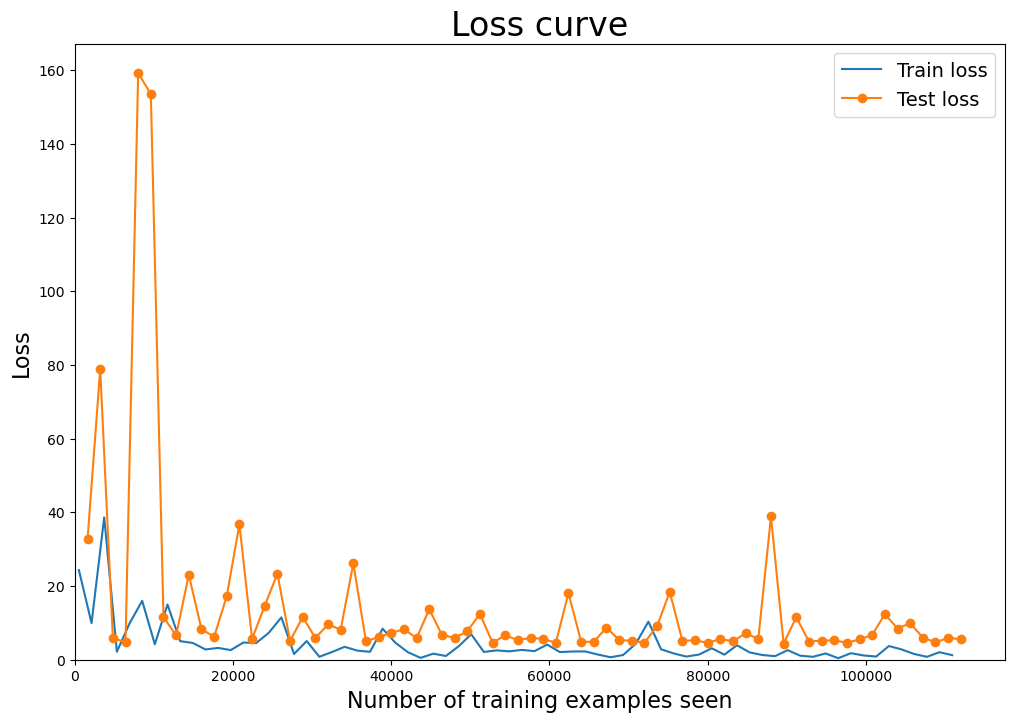

In [38]:
plt_loss_graph(train_loader, mobile_net_train_counter, mobile_net_train_losses, mobile_net_test_losses)

In [39]:
report_metrics(train_loader, test_loader, mobile_net_model, mobile_net_criterion, DEVICE)

Training Set: Average loss: 0.1468, Accuracy: 95.38%
Test Set: Average loss: 0.5592, Accuracy: 77.75%


### 4. VGG16

In [43]:
vgg_model.to(DEVICE)
vgg_train_losses, vgg_train_counter, vgg_test_losses, vgg_test_correct = model_train(train_loader,
                                                                     test_loader, vgg_model, DEVICE, vgg_criterion, 
                                                                     vgg_optimizer, vgg_epochs, 5)

Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1], Step [1/160], Loss: 820.9689331054688
Epoch [1], Step [21/160], Loss: 355.6651306152344
Epoch [1], Step [41/160], Loss: 59.047088623046875
Epoch [1], Step [61/160], Loss: 30.181440353393555
Epoch [1], Step [81/160], Loss: 31.43214225769043
Epoch [1], Step [101/160], Loss: 38.89609909057617
Epoch [1], Step [121/160], Loss: 74.75788879394531
Epoch [1], Step [141/160], Loss: 73.74139404296875


Epochs:   2%|▏         | 1/60 [00:38<37:49, 38.47s/it]

Epoch [2], Step [1/160], Loss: 61.49245834350586
Epoch [2], Step [21/160], Loss: 57.2841911315918
Epoch [2], Step [41/160], Loss: 75.0376205444336
Epoch [2], Step [61/160], Loss: 36.18648147583008
Epoch [2], Step [81/160], Loss: 28.154895782470703
Epoch [2], Step [101/160], Loss: 48.03828048706055
Epoch [2], Step [121/160], Loss: 21.489439010620117
Epoch [2], Step [141/160], Loss: 56.40925216674805


Epochs:   3%|▎         | 2/60 [01:16<37:12, 38.49s/it]

Epoch [3], Step [1/160], Loss: 125.4762191772461
Epoch [3], Step [21/160], Loss: 20.91702651977539
Epoch [3], Step [41/160], Loss: 19.17696189880371
Epoch [3], Step [61/160], Loss: 58.896400451660156
Epoch [3], Step [81/160], Loss: 44.63786315917969
Epoch [3], Step [101/160], Loss: 65.91993713378906
Epoch [3], Step [121/160], Loss: 28.76373291015625
Epoch [3], Step [141/160], Loss: 137.44810485839844


Epochs:   5%|▌         | 3/60 [01:55<36:36, 38.54s/it]

Epoch [4], Step [1/160], Loss: 123.96638488769531
Epoch [4], Step [21/160], Loss: 31.008594512939453
Epoch [4], Step [41/160], Loss: 8.494733810424805
Epoch [4], Step [61/160], Loss: 20.832015991210938
Epoch [4], Step [81/160], Loss: 25.165102005004883
Epoch [4], Step [101/160], Loss: 10.959982872009277
Epoch [4], Step [121/160], Loss: 53.27338790893555
Epoch [4], Step [141/160], Loss: 35.24044418334961


Epochs:   7%|▋         | 4/60 [02:34<36:00, 38.58s/it]

Epoch [5], Step [1/160], Loss: 18.422143936157227
Epoch [5], Step [21/160], Loss: 22.67378044128418
Epoch [5], Step [41/160], Loss: 36.7587776184082
Epoch [5], Step [61/160], Loss: 19.827163696289062
Epoch [5], Step [81/160], Loss: 25.450820922851562
Epoch [5], Step [101/160], Loss: 12.918972969055176
Epoch [5], Step [121/160], Loss: 35.3560791015625
Epoch [5], Step [141/160], Loss: 28.325958251953125


Epochs:   8%|▊         | 5/60 [03:12<35:23, 38.61s/it]

Epoch [6], Step [1/160], Loss: 32.41532516479492
Epoch [6], Step [21/160], Loss: 24.84504508972168
Epoch [6], Step [41/160], Loss: 68.63631439208984
Epoch [6], Step [61/160], Loss: 20.0850830078125
Epoch [6], Step [81/160], Loss: 93.74092102050781
Epoch [6], Step [101/160], Loss: 12.42130184173584
Epoch [6], Step [121/160], Loss: 20.5294132232666
Epoch [6], Step [141/160], Loss: 9.408036231994629


Epochs:  10%|█         | 6/60 [03:51<34:46, 38.64s/it]

Epoch [7], Step [1/160], Loss: 43.79201889038086
Epoch [7], Step [21/160], Loss: 18.89414405822754
Epoch [7], Step [41/160], Loss: 7.232625484466553
Epoch [7], Step [61/160], Loss: 44.850948333740234
Epoch [7], Step [81/160], Loss: 22.894113540649414
Epoch [7], Step [101/160], Loss: 24.640729904174805
Epoch [7], Step [121/160], Loss: 96.3517074584961
Epoch [7], Step [141/160], Loss: 47.1605110168457


Epochs:  12%|█▏        | 7/60 [04:30<34:08, 38.66s/it]

Epoch [8], Step [1/160], Loss: 39.66148376464844
Epoch [8], Step [21/160], Loss: 38.2841911315918
Epoch [8], Step [41/160], Loss: 23.159650802612305
Epoch [8], Step [61/160], Loss: 7.434684753417969
Epoch [8], Step [81/160], Loss: 9.878252029418945
Epoch [8], Step [101/160], Loss: 29.175764083862305
Epoch [8], Step [121/160], Loss: 23.513219833374023
Epoch [8], Step [141/160], Loss: 32.5938835144043


Epochs:  13%|█▎        | 8/60 [05:08<33:30, 38.67s/it]

Epoch [9], Step [1/160], Loss: 20.42364501953125
Epoch [9], Step [21/160], Loss: 27.346099853515625
Epoch [9], Step [41/160], Loss: 8.299532890319824
Epoch [9], Step [61/160], Loss: 31.410480499267578
Epoch [9], Step [81/160], Loss: 25.568647384643555
Epoch [9], Step [101/160], Loss: 62.881103515625
Epoch [9], Step [121/160], Loss: 60.31134033203125
Epoch [9], Step [141/160], Loss: 13.864412307739258


Epochs:  15%|█▌        | 9/60 [05:47<32:52, 38.68s/it]

Epoch [10], Step [1/160], Loss: 22.236539840698242
Epoch [10], Step [21/160], Loss: 76.92610931396484
Epoch [10], Step [41/160], Loss: 33.345699310302734
Epoch [10], Step [61/160], Loss: 13.313165664672852
Epoch [10], Step [81/160], Loss: 37.037376403808594
Epoch [10], Step [101/160], Loss: 32.445587158203125
Epoch [10], Step [121/160], Loss: 12.217692375183105
Epoch [10], Step [141/160], Loss: 8.894813537597656


Epochs:  17%|█▋        | 10/60 [06:26<32:14, 38.69s/it]

Epoch [11], Step [1/160], Loss: 9.429576873779297
Epoch [11], Step [21/160], Loss: 21.49201011657715
Epoch [11], Step [41/160], Loss: 15.96618366241455
Epoch [11], Step [61/160], Loss: 11.530062675476074
Epoch [11], Step [81/160], Loss: 14.063275337219238
Epoch [11], Step [101/160], Loss: 21.028972625732422
Epoch [11], Step [121/160], Loss: 12.215144157409668
Epoch [11], Step [141/160], Loss: 15.068550109863281


Epochs:  18%|█▊        | 11/60 [07:05<31:35, 38.69s/it]

Epoch [12], Step [1/160], Loss: 18.595096588134766
Epoch [12], Step [21/160], Loss: 10.349020957946777
Epoch [12], Step [41/160], Loss: 15.261186599731445
Epoch [12], Step [61/160], Loss: 7.807267665863037
Epoch [12], Step [81/160], Loss: 22.342498779296875
Epoch [12], Step [101/160], Loss: 18.089473724365234
Epoch [12], Step [121/160], Loss: 13.839492797851562
Epoch [12], Step [141/160], Loss: 18.10338592529297


Epochs:  20%|██        | 12/60 [07:43<30:57, 38.70s/it]

Epoch [13], Step [1/160], Loss: 13.411521911621094
Epoch [13], Step [21/160], Loss: 29.83135414123535
Epoch [13], Step [41/160], Loss: 16.02562713623047
Epoch [13], Step [61/160], Loss: 22.8211669921875
Epoch [13], Step [81/160], Loss: 13.980117797851562
Epoch [13], Step [101/160], Loss: 15.12822151184082
Epoch [13], Step [121/160], Loss: 14.751815795898438
Epoch [13], Step [141/160], Loss: 20.869937896728516


Epochs:  22%|██▏       | 13/60 [08:22<30:18, 38.69s/it]

Epoch [14], Step [1/160], Loss: 22.037214279174805
Epoch [14], Step [21/160], Loss: 24.007123947143555
Epoch [14], Step [41/160], Loss: 17.139524459838867
Epoch [14], Step [61/160], Loss: 10.56872844696045
Epoch [14], Step [81/160], Loss: 14.851889610290527
Epoch [14], Step [101/160], Loss: 7.791490077972412
Epoch [14], Step [121/160], Loss: 20.10080337524414
Epoch [14], Step [141/160], Loss: 10.832159042358398


Epochs:  23%|██▎       | 14/60 [09:01<29:39, 38.69s/it]

Epoch [15], Step [1/160], Loss: 16.293460845947266
Epoch [15], Step [21/160], Loss: 13.156729698181152
Epoch [15], Step [41/160], Loss: 24.30878257751465
Epoch [15], Step [61/160], Loss: 8.873515129089355
Epoch [15], Step [81/160], Loss: 13.562163352966309
Epoch [15], Step [101/160], Loss: 14.816607475280762
Epoch [15], Step [121/160], Loss: 30.02158546447754
Epoch [15], Step [141/160], Loss: 26.904190063476562


Epochs:  25%|██▌       | 15/60 [09:39<29:01, 38.69s/it]

Epoch [16], Step [1/160], Loss: 7.215489387512207
Epoch [16], Step [21/160], Loss: 47.16115188598633
Epoch [16], Step [41/160], Loss: 39.47001266479492
Epoch [16], Step [61/160], Loss: 14.677841186523438
Epoch [16], Step [81/160], Loss: 14.497323989868164
Epoch [16], Step [101/160], Loss: 20.406696319580078
Epoch [16], Step [121/160], Loss: 8.436026573181152
Epoch [16], Step [141/160], Loss: 19.69877052307129


Epochs:  27%|██▋       | 16/60 [10:18<28:22, 38.69s/it]

Epoch [17], Step [1/160], Loss: 17.69063377380371
Epoch [17], Step [21/160], Loss: 15.675048828125
Epoch [17], Step [41/160], Loss: 7.963905334472656
Epoch [17], Step [61/160], Loss: 20.564199447631836
Epoch [17], Step [81/160], Loss: 8.0292329788208
Epoch [17], Step [101/160], Loss: 31.483205795288086
Epoch [17], Step [121/160], Loss: 21.2910213470459
Epoch [17], Step [141/160], Loss: 19.97950553894043


Epochs:  28%|██▊       | 17/60 [10:57<27:43, 38.69s/it]

Epoch [18], Step [1/160], Loss: 14.044479370117188
Epoch [18], Step [21/160], Loss: 12.829489707946777
Epoch [18], Step [41/160], Loss: 18.325580596923828
Epoch [18], Step [61/160], Loss: 15.0687255859375
Epoch [18], Step [81/160], Loss: 5.939390182495117
Epoch [18], Step [101/160], Loss: 4.88826847076416
Epoch [18], Step [121/160], Loss: 10.582633018493652
Epoch [18], Step [141/160], Loss: 16.666748046875


Epochs:  30%|███       | 18/60 [11:35<27:04, 38.69s/it]

Epoch [19], Step [1/160], Loss: 22.00775146484375
Epoch [19], Step [21/160], Loss: 21.850690841674805
Epoch [19], Step [41/160], Loss: 11.004237174987793
Epoch [19], Step [61/160], Loss: 4.747257232666016
Epoch [19], Step [81/160], Loss: 3.320643186569214
Epoch [19], Step [101/160], Loss: 10.95117473602295
Epoch [19], Step [121/160], Loss: 24.384586334228516
Epoch [19], Step [141/160], Loss: 9.172259330749512


Epochs:  32%|███▏      | 19/60 [12:14<26:26, 38.69s/it]

Epoch [20], Step [1/160], Loss: 10.358420372009277
Epoch [20], Step [21/160], Loss: 5.704608917236328
Epoch [20], Step [41/160], Loss: 8.165142059326172
Epoch [20], Step [61/160], Loss: 27.866018295288086
Epoch [20], Step [81/160], Loss: 23.142105102539062
Epoch [20], Step [101/160], Loss: 15.074568748474121
Epoch [20], Step [121/160], Loss: 15.888277053833008
Epoch [20], Step [141/160], Loss: 4.518290042877197


Epochs:  33%|███▎      | 20/60 [12:53<25:47, 38.69s/it]

Epoch [21], Step [1/160], Loss: 7.677270412445068
Epoch [21], Step [21/160], Loss: 8.143162727355957
Epoch [21], Step [41/160], Loss: 18.30519676208496
Epoch [21], Step [61/160], Loss: 7.746551513671875
Epoch [21], Step [81/160], Loss: 24.179271697998047
Epoch [21], Step [101/160], Loss: 11.686578750610352
Epoch [21], Step [121/160], Loss: 16.114215850830078
Epoch [21], Step [141/160], Loss: 37.49031448364258


Epochs:  35%|███▌      | 21/60 [13:31<25:08, 38.69s/it]

Epoch [22], Step [1/160], Loss: 16.4075870513916
Epoch [22], Step [21/160], Loss: 9.84299373626709
Epoch [22], Step [41/160], Loss: 32.77427291870117
Epoch [22], Step [61/160], Loss: 3.425262928009033
Epoch [22], Step [81/160], Loss: 4.020899772644043
Epoch [22], Step [101/160], Loss: 13.387018203735352
Epoch [22], Step [121/160], Loss: 12.779936790466309
Epoch [22], Step [141/160], Loss: 14.725259780883789


Epochs:  37%|███▋      | 22/60 [14:10<24:30, 38.69s/it]

Epoch [23], Step [1/160], Loss: 23.11238670349121
Epoch [23], Step [21/160], Loss: 11.19625473022461
Epoch [23], Step [41/160], Loss: 8.87976360321045
Epoch [23], Step [61/160], Loss: 19.247949600219727
Epoch [23], Step [81/160], Loss: 5.594233989715576
Epoch [23], Step [101/160], Loss: 14.621612548828125
Epoch [23], Step [121/160], Loss: 8.520553588867188
Epoch [23], Step [141/160], Loss: 6.095805644989014


Epochs:  38%|███▊      | 23/60 [14:49<23:51, 38.69s/it]

Epoch [24], Step [1/160], Loss: 15.721270561218262
Epoch [24], Step [21/160], Loss: 12.0173921585083
Epoch [24], Step [41/160], Loss: 15.409148216247559
Epoch [24], Step [61/160], Loss: 15.647345542907715
Epoch [24], Step [81/160], Loss: 15.060637474060059
Epoch [24], Step [101/160], Loss: 15.807356834411621
Epoch [24], Step [121/160], Loss: 11.31001091003418
Epoch [24], Step [141/160], Loss: 18.05661964416504


Epochs:  40%|████      | 24/60 [15:27<23:12, 38.68s/it]

Epoch [25], Step [1/160], Loss: 9.798129081726074
Epoch [25], Step [21/160], Loss: 8.582159042358398
Epoch [25], Step [41/160], Loss: 4.929507732391357
Epoch [25], Step [61/160], Loss: 8.48532485961914
Epoch [25], Step [81/160], Loss: 11.512969017028809
Epoch [25], Step [101/160], Loss: 4.823178291320801
Epoch [25], Step [121/160], Loss: 19.745946884155273
Epoch [25], Step [141/160], Loss: 11.820391654968262


Epochs:  42%|████▏     | 25/60 [16:06<22:33, 38.67s/it]

Epoch [26], Step [1/160], Loss: 18.14532470703125
Epoch [26], Step [21/160], Loss: 18.98489761352539
Epoch [26], Step [41/160], Loss: 5.788311004638672
Epoch [26], Step [61/160], Loss: 14.48685359954834
Epoch [26], Step [81/160], Loss: 6.058791637420654
Epoch [26], Step [101/160], Loss: 17.58559799194336
Epoch [26], Step [121/160], Loss: 14.940386772155762
Epoch [26], Step [141/160], Loss: 6.454451084136963


Epochs:  43%|████▎     | 26/60 [16:45<21:54, 38.67s/it]

Epoch [27], Step [1/160], Loss: 15.946850776672363
Epoch [27], Step [21/160], Loss: 20.09614372253418
Epoch [27], Step [41/160], Loss: 14.399945259094238
Epoch [27], Step [61/160], Loss: 12.030529975891113
Epoch [27], Step [81/160], Loss: 19.196441650390625
Epoch [27], Step [101/160], Loss: 10.819012641906738
Epoch [27], Step [121/160], Loss: 12.519110679626465
Epoch [27], Step [141/160], Loss: 15.955538749694824


Epochs:  45%|████▌     | 27/60 [17:23<21:16, 38.67s/it]

Epoch [28], Step [1/160], Loss: 4.542718410491943
Epoch [28], Step [21/160], Loss: 20.182300567626953
Epoch [28], Step [41/160], Loss: 5.0040602684021
Epoch [28], Step [61/160], Loss: 7.924195766448975
Epoch [28], Step [81/160], Loss: 22.522737503051758
Epoch [28], Step [101/160], Loss: 5.77096700668335
Epoch [28], Step [121/160], Loss: 20.4800968170166
Epoch [28], Step [141/160], Loss: 23.464801788330078


Epochs:  47%|████▋     | 28/60 [18:02<20:37, 38.66s/it]

Epoch [29], Step [1/160], Loss: 17.0716609954834
Epoch [29], Step [21/160], Loss: 17.264739990234375
Epoch [29], Step [41/160], Loss: 7.252479553222656
Epoch [29], Step [61/160], Loss: 7.225801944732666
Epoch [29], Step [81/160], Loss: 4.64925479888916
Epoch [29], Step [101/160], Loss: 12.64646053314209
Epoch [29], Step [121/160], Loss: 27.084012985229492
Epoch [29], Step [141/160], Loss: 15.802780151367188


Epochs:  48%|████▊     | 29/60 [18:41<19:58, 38.66s/it]

Epoch [30], Step [1/160], Loss: 11.016258239746094
Epoch [30], Step [21/160], Loss: 43.58195114135742
Epoch [30], Step [41/160], Loss: 9.353944778442383
Epoch [30], Step [61/160], Loss: 26.623584747314453
Epoch [30], Step [81/160], Loss: 15.912678718566895
Epoch [30], Step [101/160], Loss: 10.977347373962402
Epoch [30], Step [121/160], Loss: 10.266448020935059
Epoch [30], Step [141/160], Loss: 21.011510848999023


Epochs:  50%|█████     | 30/60 [19:19<19:19, 38.65s/it]

Epoch [31], Step [1/160], Loss: 17.759214401245117
Epoch [31], Step [21/160], Loss: 12.188013076782227
Epoch [31], Step [41/160], Loss: 22.618589401245117
Epoch [31], Step [61/160], Loss: 8.215651512145996
Epoch [31], Step [81/160], Loss: 7.0674943923950195
Epoch [31], Step [101/160], Loss: 15.371859550476074
Epoch [31], Step [121/160], Loss: 9.396601676940918
Epoch [31], Step [141/160], Loss: 15.10015869140625


Epochs:  52%|█████▏    | 31/60 [19:58<18:40, 38.64s/it]

Epoch [32], Step [1/160], Loss: 23.783727645874023
Epoch [32], Step [21/160], Loss: 15.4954195022583
Epoch [32], Step [41/160], Loss: 7.133584499359131
Epoch [32], Step [61/160], Loss: 10.142219543457031
Epoch [32], Step [81/160], Loss: 8.045183181762695
Epoch [32], Step [101/160], Loss: 10.339424133300781
Epoch [32], Step [121/160], Loss: 17.70549964904785
Epoch [32], Step [141/160], Loss: 25.8994140625


Epochs:  53%|█████▎    | 32/60 [20:37<18:01, 38.64s/it]

Epoch [33], Step [1/160], Loss: 12.123055458068848
Epoch [33], Step [21/160], Loss: 12.198070526123047
Epoch [33], Step [41/160], Loss: 6.592318058013916
Epoch [33], Step [61/160], Loss: 13.054408073425293
Epoch [33], Step [81/160], Loss: 21.18587303161621
Epoch [33], Step [101/160], Loss: 9.69873046875
Epoch [33], Step [121/160], Loss: 21.9036922454834
Epoch [33], Step [141/160], Loss: 8.971925735473633


Epochs:  55%|█████▌    | 33/60 [21:15<17:23, 38.64s/it]

Epoch [34], Step [1/160], Loss: 9.963529586791992
Epoch [34], Step [21/160], Loss: 10.172350883483887
Epoch [34], Step [41/160], Loss: 15.19327449798584
Epoch [34], Step [61/160], Loss: 13.681419372558594
Epoch [34], Step [81/160], Loss: 14.9912748336792
Epoch [34], Step [101/160], Loss: 6.366207599639893
Epoch [34], Step [121/160], Loss: 29.44272232055664
Epoch [34], Step [141/160], Loss: 10.843972206115723


Epochs:  57%|█████▋    | 34/60 [21:54<16:44, 38.63s/it]

Epoch [35], Step [1/160], Loss: 34.109230041503906
Epoch [35], Step [21/160], Loss: 13.811659812927246
Epoch [35], Step [41/160], Loss: 10.318193435668945
Epoch [35], Step [61/160], Loss: 17.045480728149414
Epoch [35], Step [81/160], Loss: 10.598628044128418
Epoch [35], Step [101/160], Loss: 9.078885078430176
Epoch [35], Step [121/160], Loss: 24.578929901123047
Epoch [35], Step [141/160], Loss: 15.391913414001465


Epochs:  58%|█████▊    | 35/60 [22:33<16:05, 38.62s/it]

Epoch [36], Step [1/160], Loss: 16.160457611083984
Epoch [36], Step [21/160], Loss: 48.84382247924805
Epoch [36], Step [41/160], Loss: 14.051861763000488
Epoch [36], Step [61/160], Loss: 12.178298950195312
Epoch [36], Step [81/160], Loss: 25.465984344482422
Epoch [36], Step [101/160], Loss: 12.945581436157227
Epoch [36], Step [121/160], Loss: 20.24665069580078
Epoch [36], Step [141/160], Loss: 14.03098201751709


Epochs:  60%|██████    | 36/60 [23:11<15:26, 38.62s/it]

Epoch [37], Step [1/160], Loss: 16.001585006713867
Epoch [37], Step [21/160], Loss: 37.225643157958984
Epoch [37], Step [41/160], Loss: 7.449221134185791
Epoch [37], Step [61/160], Loss: 10.482039451599121
Epoch [37], Step [81/160], Loss: 17.104597091674805
Epoch [37], Step [101/160], Loss: 7.748335361480713
Epoch [37], Step [121/160], Loss: 15.583706855773926
Epoch [37], Step [141/160], Loss: 14.237579345703125


Epochs:  62%|██████▏   | 37/60 [23:50<14:48, 38.62s/it]

Epoch [38], Step [1/160], Loss: 8.951075553894043
Epoch [38], Step [21/160], Loss: 9.702345848083496
Epoch [38], Step [41/160], Loss: 6.526649475097656
Epoch [38], Step [61/160], Loss: 12.729018211364746
Epoch [38], Step [81/160], Loss: 22.436765670776367
Epoch [38], Step [101/160], Loss: 4.342313289642334
Epoch [38], Step [121/160], Loss: 21.520517349243164
Epoch [38], Step [141/160], Loss: 9.747751235961914


Epochs:  63%|██████▎   | 38/60 [24:28<14:09, 38.62s/it]

Epoch [39], Step [1/160], Loss: 5.80659294128418
Epoch [39], Step [21/160], Loss: 9.50456714630127
Epoch [39], Step [41/160], Loss: 10.361964225769043
Epoch [39], Step [61/160], Loss: 14.433667182922363
Epoch [39], Step [81/160], Loss: 21.589889526367188
Epoch [39], Step [101/160], Loss: 5.620316982269287
Epoch [39], Step [121/160], Loss: 7.260847568511963
Epoch [39], Step [141/160], Loss: 6.5884857177734375


Epochs:  65%|██████▌   | 39/60 [25:07<13:30, 38.62s/it]

Epoch [40], Step [1/160], Loss: 23.042898178100586
Epoch [40], Step [21/160], Loss: 18.195589065551758
Epoch [40], Step [41/160], Loss: 5.944829940795898
Epoch [40], Step [61/160], Loss: 9.851912498474121
Epoch [40], Step [81/160], Loss: 2.2150790691375732
Epoch [40], Step [101/160], Loss: 29.212934494018555
Epoch [40], Step [121/160], Loss: 7.016452312469482
Epoch [40], Step [141/160], Loss: 12.19998836517334


Epochs:  67%|██████▋   | 40/60 [25:46<12:52, 38.61s/it]

Epoch [41], Step [1/160], Loss: 9.145992279052734
Epoch [41], Step [21/160], Loss: 16.083295822143555
Epoch [41], Step [41/160], Loss: 30.436115264892578
Epoch [41], Step [61/160], Loss: 48.259944915771484
Epoch [41], Step [81/160], Loss: 6.195044994354248
Epoch [41], Step [101/160], Loss: 9.124999046325684
Epoch [41], Step [121/160], Loss: 13.081329345703125
Epoch [41], Step [141/160], Loss: 17.1892147064209


Epochs:  68%|██████▊   | 41/60 [26:24<12:13, 38.60s/it]

Epoch [42], Step [1/160], Loss: 8.15438461303711
Epoch [42], Step [21/160], Loss: 13.476663589477539
Epoch [42], Step [41/160], Loss: 8.766325950622559
Epoch [42], Step [61/160], Loss: 7.831631660461426
Epoch [42], Step [81/160], Loss: 31.184329986572266
Epoch [42], Step [101/160], Loss: 15.60123348236084
Epoch [42], Step [121/160], Loss: 9.863762855529785
Epoch [42], Step [141/160], Loss: 5.157124042510986


Epochs:  70%|███████   | 42/60 [27:03<11:34, 38.61s/it]

Epoch [43], Step [1/160], Loss: 8.502882957458496
Epoch [43], Step [21/160], Loss: 5.081662178039551
Epoch [43], Step [41/160], Loss: 4.0786614418029785
Epoch [43], Step [61/160], Loss: 21.56599998474121
Epoch [43], Step [81/160], Loss: 18.47601318359375
Epoch [43], Step [101/160], Loss: 21.3436222076416
Epoch [43], Step [121/160], Loss: 14.371405601501465
Epoch [43], Step [141/160], Loss: 11.891265869140625


Epochs:  72%|███████▏  | 43/60 [27:41<10:56, 38.61s/it]

Epoch [44], Step [1/160], Loss: 17.493053436279297
Epoch [44], Step [21/160], Loss: 30.90335464477539
Epoch [44], Step [41/160], Loss: 43.12689208984375
Epoch [44], Step [61/160], Loss: 51.64046859741211
Epoch [44], Step [81/160], Loss: 18.466552734375
Epoch [44], Step [101/160], Loss: 26.106250762939453
Epoch [44], Step [121/160], Loss: 18.408905029296875
Epoch [44], Step [141/160], Loss: 2.350023031234741


Epochs:  73%|███████▎  | 44/60 [28:20<10:17, 38.60s/it]

Epoch [45], Step [1/160], Loss: 10.79324722290039
Epoch [45], Step [21/160], Loss: 5.621480941772461
Epoch [45], Step [41/160], Loss: 13.446188926696777
Epoch [45], Step [61/160], Loss: 15.084721565246582
Epoch [45], Step [81/160], Loss: 39.54539108276367
Epoch [45], Step [101/160], Loss: 8.822211265563965
Epoch [45], Step [121/160], Loss: 27.87017250061035
Epoch [45], Step [141/160], Loss: 18.06253433227539


Epochs:  75%|███████▌  | 45/60 [28:59<09:38, 38.59s/it]

Epoch [46], Step [1/160], Loss: 12.807271003723145
Epoch [46], Step [21/160], Loss: 9.119279861450195
Epoch [46], Step [41/160], Loss: 26.092700958251953
Epoch [46], Step [61/160], Loss: 23.799856185913086
Epoch [46], Step [81/160], Loss: 20.174612045288086
Epoch [46], Step [101/160], Loss: 23.822568893432617
Epoch [46], Step [121/160], Loss: 10.192151069641113
Epoch [46], Step [141/160], Loss: 20.38055992126465


Epochs:  77%|███████▋  | 46/60 [29:37<09:00, 38.59s/it]

Epoch [47], Step [1/160], Loss: 20.478076934814453
Epoch [47], Step [21/160], Loss: 14.115141868591309
Epoch [47], Step [41/160], Loss: 9.108278274536133
Epoch [47], Step [61/160], Loss: 18.128353118896484
Epoch [47], Step [81/160], Loss: 35.699066162109375
Epoch [47], Step [101/160], Loss: 6.353191375732422
Epoch [47], Step [121/160], Loss: 17.819231033325195
Epoch [47], Step [141/160], Loss: 31.069921493530273


Epochs:  78%|███████▊  | 47/60 [30:16<08:21, 38.58s/it]

Epoch [48], Step [1/160], Loss: 32.15857696533203
Epoch [48], Step [21/160], Loss: 14.847273826599121
Epoch [48], Step [41/160], Loss: 13.685261726379395
Epoch [48], Step [61/160], Loss: 14.359024047851562
Epoch [48], Step [81/160], Loss: 7.7052202224731445
Epoch [48], Step [101/160], Loss: 3.5077569484710693
Epoch [48], Step [121/160], Loss: 10.817363739013672
Epoch [48], Step [141/160], Loss: 16.084280014038086


Epochs:  80%|████████  | 48/60 [30:54<07:43, 38.59s/it]

Epoch [49], Step [1/160], Loss: 42.23561477661133
Epoch [49], Step [21/160], Loss: 7.847743511199951
Epoch [49], Step [41/160], Loss: 5.73721170425415
Epoch [49], Step [61/160], Loss: 9.602381706237793
Epoch [49], Step [81/160], Loss: 12.961575508117676
Epoch [49], Step [101/160], Loss: 21.992918014526367
Epoch [49], Step [121/160], Loss: 13.74112606048584
Epoch [49], Step [141/160], Loss: 9.987622261047363


Epochs:  82%|████████▏ | 49/60 [31:33<07:04, 38.58s/it]

Epoch [50], Step [1/160], Loss: 13.005057334899902
Epoch [50], Step [21/160], Loss: 13.54747486114502
Epoch [50], Step [41/160], Loss: 11.562091827392578
Epoch [50], Step [61/160], Loss: 15.275639533996582
Epoch [50], Step [81/160], Loss: 30.257070541381836
Epoch [50], Step [101/160], Loss: 18.27055549621582
Epoch [50], Step [121/160], Loss: 25.649280548095703
Epoch [50], Step [141/160], Loss: 40.36143112182617


Epochs:  83%|████████▎ | 50/60 [32:11<06:25, 38.58s/it]

Epoch [51], Step [1/160], Loss: 8.631834983825684
Epoch [51], Step [21/160], Loss: 17.70969581604004
Epoch [51], Step [41/160], Loss: 14.871817588806152
Epoch [51], Step [61/160], Loss: 5.980712413787842
Epoch [51], Step [81/160], Loss: 8.16064453125
Epoch [51], Step [101/160], Loss: 15.667288780212402
Epoch [51], Step [121/160], Loss: 14.342299461364746
Epoch [51], Step [141/160], Loss: 5.585063457489014


Epochs:  85%|████████▌ | 51/60 [32:50<05:47, 38.58s/it]

Epoch [52], Step [1/160], Loss: 25.342710494995117
Epoch [52], Step [21/160], Loss: 7.365847110748291
Epoch [52], Step [41/160], Loss: 9.343098640441895
Epoch [52], Step [61/160], Loss: 23.040531158447266
Epoch [52], Step [81/160], Loss: 13.75597858428955
Epoch [52], Step [101/160], Loss: 18.427244186401367
Epoch [52], Step [121/160], Loss: 18.814340591430664
Epoch [52], Step [141/160], Loss: 30.107419967651367


Epochs:  87%|████████▋ | 52/60 [33:29<05:08, 38.57s/it]

Epoch [53], Step [1/160], Loss: 11.500067710876465
Epoch [53], Step [21/160], Loss: 26.929746627807617
Epoch [53], Step [41/160], Loss: 24.773704528808594
Epoch [53], Step [61/160], Loss: 13.058104515075684
Epoch [53], Step [81/160], Loss: 9.518028259277344
Epoch [53], Step [101/160], Loss: 15.368878364562988
Epoch [53], Step [121/160], Loss: 10.269331932067871
Epoch [53], Step [141/160], Loss: 13.387507438659668


Epochs:  88%|████████▊ | 53/60 [34:07<04:29, 38.57s/it]

Epoch [54], Step [1/160], Loss: 8.284249305725098
Epoch [54], Step [21/160], Loss: 7.017324924468994
Epoch [54], Step [41/160], Loss: 9.905179023742676
Epoch [54], Step [61/160], Loss: 8.558880805969238
Epoch [54], Step [81/160], Loss: 12.438878059387207
Epoch [54], Step [101/160], Loss: 11.860055923461914
Epoch [54], Step [121/160], Loss: 11.440581321716309
Epoch [54], Step [141/160], Loss: 13.200064659118652


Epochs:  90%|█████████ | 54/60 [34:46<03:51, 38.57s/it]

Epoch [55], Step [1/160], Loss: 8.105853080749512
Epoch [55], Step [21/160], Loss: 19.250165939331055
Epoch [55], Step [41/160], Loss: 8.965323448181152
Epoch [55], Step [61/160], Loss: 7.747805118560791
Epoch [55], Step [81/160], Loss: 17.395612716674805
Epoch [55], Step [101/160], Loss: 10.44388484954834
Epoch [55], Step [121/160], Loss: 11.110353469848633
Epoch [55], Step [141/160], Loss: 14.923304557800293


Epochs:  92%|█████████▏| 55/60 [35:24<03:12, 38.57s/it]

Epoch [56], Step [1/160], Loss: 20.0063419342041
Epoch [56], Step [21/160], Loss: 18.907730102539062
Epoch [56], Step [41/160], Loss: 12.809836387634277
Epoch [56], Step [61/160], Loss: 26.849979400634766
Epoch [56], Step [81/160], Loss: 6.253812313079834
Epoch [56], Step [101/160], Loss: 12.56818675994873
Epoch [56], Step [121/160], Loss: 12.270636558532715
Epoch [56], Step [141/160], Loss: 10.262168884277344


Epochs:  93%|█████████▎| 56/60 [36:03<02:34, 38.56s/it]

Epoch [57], Step [1/160], Loss: 17.114103317260742
Epoch [57], Step [21/160], Loss: 28.206083297729492
Epoch [57], Step [41/160], Loss: 10.844380378723145
Epoch [57], Step [61/160], Loss: 9.991179466247559
Epoch [57], Step [81/160], Loss: 15.701316833496094
Epoch [57], Step [101/160], Loss: 11.150516510009766
Epoch [57], Step [121/160], Loss: 3.5959270000457764
Epoch [57], Step [141/160], Loss: 10.643841743469238


Epochs:  95%|█████████▌| 57/60 [36:41<01:55, 38.55s/it]

Epoch [58], Step [1/160], Loss: 14.535675048828125
Epoch [58], Step [21/160], Loss: 11.777281761169434
Epoch [58], Step [41/160], Loss: 8.160412788391113
Epoch [58], Step [61/160], Loss: 26.156064987182617
Epoch [58], Step [81/160], Loss: 13.874249458312988
Epoch [58], Step [101/160], Loss: 41.7488899230957
Epoch [58], Step [121/160], Loss: 10.684025764465332
Epoch [58], Step [141/160], Loss: 23.68083953857422


Epochs:  97%|█████████▋| 58/60 [37:20<01:17, 38.55s/it]

Epoch [59], Step [1/160], Loss: 14.499496459960938
Epoch [59], Step [21/160], Loss: 8.609810829162598
Epoch [59], Step [41/160], Loss: 28.997730255126953
Epoch [59], Step [61/160], Loss: 21.28994369506836
Epoch [59], Step [81/160], Loss: 12.908021926879883
Epoch [59], Step [101/160], Loss: 12.173194885253906
Epoch [59], Step [121/160], Loss: 8.492738723754883
Epoch [59], Step [141/160], Loss: 4.988540172576904


Epochs:  98%|█████████▊| 59/60 [37:58<00:38, 38.54s/it]

Epoch [60], Step [1/160], Loss: 21.12554931640625
Epoch [60], Step [21/160], Loss: 20.62082862854004
Epoch [60], Step [41/160], Loss: 6.830732822418213
Epoch [60], Step [61/160], Loss: 14.714827537536621
Epoch [60], Step [81/160], Loss: 10.319830894470215
Epoch [60], Step [101/160], Loss: 5.446845531463623
Epoch [60], Step [121/160], Loss: 9.54775333404541
Epoch [60], Step [141/160], Loss: 9.855925559997559


Epochs: 100%|██████████| 60/60 [38:37<00:00, 38.62s/it]


Test accuracy: 0.12


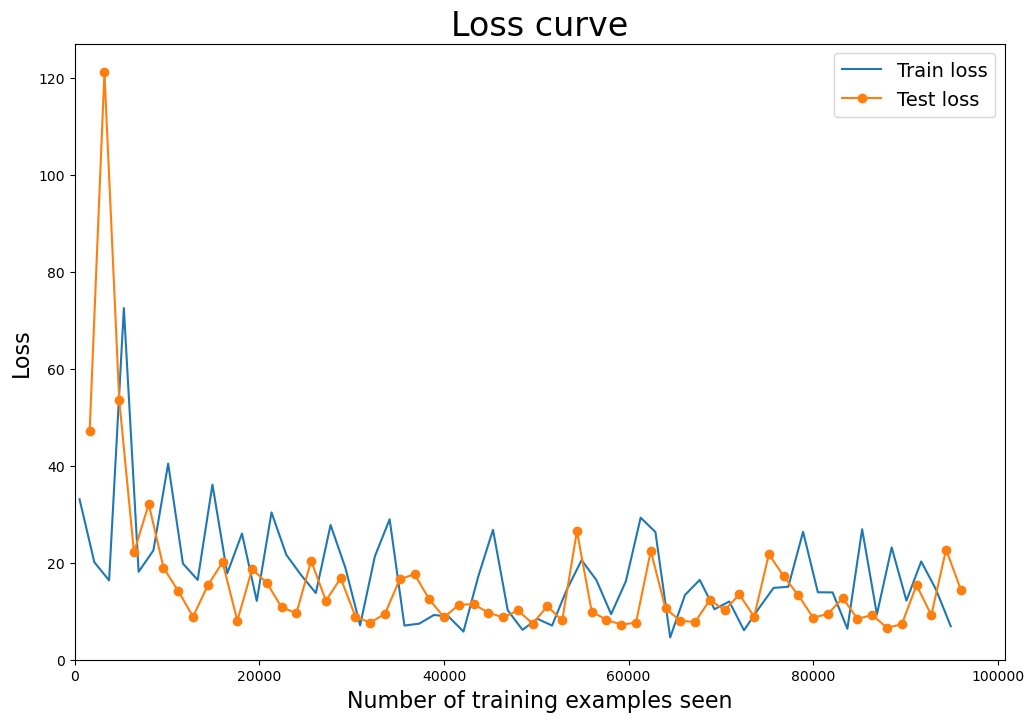

In [44]:
plt_loss_graph(train_loader, vgg_train_counter, vgg_train_losses, vgg_test_losses)

In [45]:
report_metrics(train_loader, test_loader, vgg_model, vgg_criterion, DEVICE)

Training Set: Average loss: 0.8667, Accuracy: 71.62%
Test Set: Average loss: 1.4430, Accuracy: 59.25%
